# Shallow Water Model, With Experiments

### 1. Introduction

This python notebook solves the non-linear shallow water equations on a Cartesian beta plane in a channel, with several different options for model set-up to illustrate a range of meteorological phenomenona.

The code and experiment set was originally programed in MATLAB by Robin Hogan and translated to python by Paul Connolly. It was hacked roughly into notebook form by Matt Barlow, with a few additional features added, ignoring all principles of robust coding. If you have any questions, find any bugs, or develop any improvements please email Mathew_Barlow@uml.edu.  

A separate pdf file, swe_notes.pdf, further describes the different intial conditions and configurations.

Possible initial conditions of the height field include:

    UNIFORM_WESTERLY
    ZONAL_JET
    REANALYSIS (requires reanalysis.mat file)
    GAUSSIAN_BLOB
    GAUSSIAN_LOW
    STEP
    CYCLONE_IN_WESTERLY
    SHARP_SHEAR
    EQUATORIAL_EASTERLY
    SINUSOIDAL

Possible configurations of the orography include:

    FLAT
    SLOPE
    GAUSSIAN_MOUNTAIN
    EARTH_OROGRAPHY (requires digital_elevation_map.mat file)
    SEA_MOUNT

An option is provided to add random noise and the values of f0 and beta can be set. The initial wind field can be set to geostrophic or at rest (no winds). A second version of the model that runs from user-specified initial conditons also may be used.

Functions are provided to make plots and animations of the model output.

The model and plotting code is contained in Sections 2 and 3. These sections need to be run first, although they do not need to be changed for the different experiments. Information on how to run the model and an example run is provided in Section 4. Information and examples on plotting are provided in Section 5. Section 6 runs through some of the possible experiments and Section 7 gives some examples of setting your own initial conditions.

Initial beta release of notebook on 13 Oct 2023.

Support from NSF AGS-1623912, NSF AGS-1657921, and NOAA MAPP NA20OAR4310424 is gratefully acknowledged.

### 2. Set up and define model

In [1]:
# copyrights and links for Robin and Paul

# Copyright (c) 2014 by Robin Hogan
#
# Copying and distribution of this file, with or without modification,
# are permitted in any medium without royalty provided the copyright
# notice and this notice are preserved.  This file is offered as-is,
# without any warranty.

# http://www.met.reading.ac.uk/~swrhgnrj/shallow_water_model/

# Copyright (c) 2017 by Paul Connolly
#
# Copying and distribution of this file, with or without modification,
# are permitted in any medium without royalty provided the copyright
# notice and this notice are preserved.  This file is offered as-is,
# without any warranty.

# https://personalpages.manchester.ac.uk/staff/paul.connolly/teaching/practicals/shallow_water_equations.html

In [2]:
# import needed packages

import numpy as np
import sys
import time
import scipy.io as sio
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import os
import imageio
from scipy.interpolate import RegularGridInterpolator

In [3]:
# define Lax-Wendroff time-stepping scheme

def lax_wendroff(dx, dy, dt, g, u, v, h, u_tendency, v_tendency):

   # This function performs one timestep of the Lax-Wendroff scheme
   # applied to the shallow water equations

   # First work out mid-point values in time and space
   uh = u*h;
   vh = v*h;

   h_mid_xt = 0.5*(h[1:,:]+h[0:-1,:]) \
      -(0.5*dt/dx)*(uh[1:,:]-uh[0:-1,:]);
   h_mid_yt = 0.5*(h[:,1:]+h[:,0:-1]) \
      -(0.5*dt/dy)*(vh[:,1:]-vh[:,0:-1]);

   Ux = uh*u+0.5*g*h**2.;
   Uy = uh*v;
   uh_mid_xt = 0.5*(uh[1:,:]+uh[0:-1,:]) \
      -(0.5*dt/dx)*(Ux[1:,:]-Ux[0:-1,:]);
   uh_mid_yt = 0.5*(uh[:,1:]+uh[:,0:-1]) \
      -(0.5*dt/dy)*(Uy[:,1:]-Uy[:,0:-1]);

   Vx = Uy;
   Vy = vh*v+0.5*g*h**2.;
   vh_mid_xt = 0.5*(vh[1:,:]+vh[0:-1,:]) \
      -(0.5*dt/dx)*(Vx[1:,:]-Vx[0:-1,:]);
   vh_mid_yt = 0.5*(vh[:,1:]+vh[:,0:-1]) \
      -(0.5*dt/dy)*(Vy[:,1:]-Vy[:,0:-1]);

   # Now use the mid-point values to predict the values at the next
   # timestep
   h_new = h[1:-1,1:-1] \
      - (dt/dx)*(uh_mid_xt[1:,1:-1]-uh_mid_xt[0:-1,1:-1]) \
      - (dt/dy)*(vh_mid_yt[1:-1,1:]-vh_mid_yt[1:-1,0:-1]);


   Ux_mid_xt = uh_mid_xt*uh_mid_xt/h_mid_xt + 0.5*g*h_mid_xt**2.;
   Uy_mid_yt = uh_mid_yt*vh_mid_yt/h_mid_yt;
   uh_new = uh[1:-1,1:-1] \
      - (dt/dx)*(Ux_mid_xt[1:,1:-1]-Ux_mid_xt[0:-1,1:-1]) \
      - (dt/dy)*(Uy_mid_yt[1:-1,1:]-Uy_mid_yt[1:-1,0:-1]) \
      + dt*u_tendency*0.5*(h[1:-1,1:-1]+h_new);


   Vx_mid_xt = uh_mid_xt*vh_mid_xt/h_mid_xt;
   Vy_mid_yt = vh_mid_yt*vh_mid_yt/h_mid_yt + 0.5*g*h_mid_yt**2.;
   vh_new = vh[1:-1,1:-1] \
      - (dt/dx)*(Vx_mid_xt[1:,1:-1]-Vx_mid_xt[0:-1,1:-1]) \
      - (dt/dy)*(Vy_mid_yt[1:-1,1:]-Vy_mid_yt[1:-1,0:-1]) \
      + dt*v_tendency*0.5*(h[1:-1,1:-1]+h_new);
   u_new = uh_new/h_new;
   v_new = vh_new/h_new;
   
   return (u_new, v_new, h_new)


In [4]:
# defintions, set-up and heart of the model code

# some definitions 

# Possible initial conditions of the height field
UNIFORM_WESTERLY=1
ZONAL_JET=2
REANALYSIS=3
GAUSSIAN_BLOB=4
STEP=5
CYCLONE_IN_WESTERLY=6
SHARP_SHEAR=7
EQUATORIAL_EASTERLY=8
SINUSOIDAL=9
GAUSSIAN_LOW=10

# Possible orographies
FLAT=0
SLOPE=1
GAUSSIAN_MOUNTAIN=2
EARTH_OROGRAPHY=3
SEA_MOUNT=4


# define function to run model
# output variables are: u_save, v_save, h_save, t_save, H, X, and Y

def run_model(orography = FLAT, 
              initial_conditions = ZONAL_JET,
              initially_geostrophic = True,
              add_random_height_noise = True,
              g = 9.81,
              f0 = 1e-4,
              beta = 1.6e-11,
              dt_mins = 1.,
              output_interval_mins = 60.,
              forecast_length_days = 4.,
              nx = 254,
              ny = 50, 
              dx = 111.86e3,
              dy = 100.00e3):

    # g: Acceleration due to gravity (m/s2)
    # f0: Coriolis parameter const. (s-1), default at 45N
    # beta: Meridional gradient of f (s-1m-1), default at 45N
    # omega: angular velocity of Earth (s-1)
    # re: radius of Earth (m)

    # dt_mins: timestep (minutes)
    # output_interval_mins: time between outputs (minutes)
    # forecast_length_days: total simulation length (days)
    
    # nx: number of zonal gridpoints
    # ny: number of meridional gridpoints
    # If you change the number of gridpoints then orography=EARTH_OROGRAPHY
    # or initial_conditions=REANALYSIS won't work

    # dx: Zonal grid spacing (m)
    # dy: Meridional grid spacing (m)
    
    x=np.mgrid[0:nx]*dx; # Zonal distance coordinate (m)
    y=np.mgrid[0:ny]*dy; # Meridional distance coordinate (m)
    y = y - np.mean(y) # y=0 in the middle of its domain
                   # interpretation of y=0 is determined by choice of f0 and beta
    [Y,X] = np.meshgrid(y,x); # Create matrices of the coordinate variables

    
    dt = dt_mins*60.0; # Timestep (s)
    output_interval = output_interval_mins*60.0; # Time between outputs (s)
    forecast_length = forecast_length_days*24.0*3600.0; # Forecast length (s)
    nt = int(np.fix(forecast_length/dt)+1); # Number of timesteps
    timesteps_between_outputs = np.fix(output_interval/dt);
    noutput = int(np.ceil(nt/timesteps_between_outputs)); # Number of output frames
 
    # output, with interval specified by output_interval_mins
    u_save = np.zeros((nx, ny, noutput))
    v_save = np.zeros((nx, ny, noutput))
    h_save = np.zeros((nx, ny, noutput))
    t_save = np.zeros((noutput,1))

    # SHALLOW WATER MODEL
    #
    # This model integrates the shallow water equations in conservative form
    # in a channel using the Lax-Wendroff method.  It can be used to
    # illustrate a number of meteorological phenomena.

    # Create the orography field "H"
    if orography == FLAT:
       H = np.zeros((nx, ny));
    elif orography == SLOPE:
       H = 9000.*2.*np.abs((np.mean(x)-X)/np.max(x));
    elif orography == GAUSSIAN_MOUNTAIN:
       std_mountain_x = 6.*dx; # Std. dev. of mountain in x direction (m)
       std_mountain_y = 6.*dy; # Std. dev. of mountain in y direction (m)
       H = 5000.*np.exp(-0.5*((X-np.mean(x))/std_mountain_x)**2. \
                      -0.5*((Y-np.mean(y))/std_mountain_y)**2.);
    elif orography == SEA_MOUNT:
       std_mountain = 40.0*dy; # Standard deviation of mountain (m)
       H = 9250.*np.exp(-((X-np.mean(x))**2.+(Y-0.5*np.mean(y))**2.)/(2.*std_mountain**2.));
    elif orography == EARTH_OROGRAPHY:
       mat_contents = sio.loadmat('digital_elevation_map.mat')
       H = mat_contents['elevation'];
       # Enforce periodic boundary conditions in x
       H[0, :] = H[-2, :]
       H[-1, :] = H[1, :]
#       H[[0, -1],:]=H[[-2, 1],:];
        
    else:
       print('Don''t know what to do with orography=' + np.num2str(orography)); 
       sys.exit()


    # Coriolis parameter as a matrix of values varying in y only
    F = f0+beta*Y # Y is zero in the middle of its range

    # Create the initial height field 
    if initial_conditions == UNIFORM_WESTERLY:
       mean_wind_speed = 20.; # m/s
    
       # note change from original code
       height = 10000.-(mean_wind_speed*f0/g)*Y \
                - 0.5*(mean_wind_speed*beta/g)*Y**2

    elif initial_conditions == SINUSOIDAL:
       height = 10000.-350.*np.sin(Y/(np.max(y))*2.0*np.pi);
    elif initial_conditions == EQUATORIAL_EASTERLY:
       height = 10000. - 50.*np.cos(Y*2*np.pi/np.max(y))
    elif initial_conditions == ZONAL_JET:
       height = 10000. - np.tanh(20.0*((Y-np.mean(y))/np.max(y)))*400.;
    elif initial_conditions == REANALYSIS:
       mat_contents = sio.loadmat('reanalysis.mat')
       pressure = mat_contents['pressure'];
       height = 0.99*pressure/g;
    elif initial_conditions == GAUSSIAN_BLOB:
       std_blob = 8.0*dy; # Standard deviation of blob (m)
       height = 9750. + 1000.*np.exp(-((X-0.25*np.mean(x))**2.+(Y-np.mean(y))**2.)/(2.* \
                                                         std_blob**2.));
    elif initial_conditions == GAUSSIAN_LOW:
       std_blob = 8.0*dy; # Standard deviation of blob (m)
       height = 9750. - 1000.*np.exp(-((X-np.mean(x))**2.+(Y-np.mean(y))**2.)/(2.* \
                                                         std_blob**2.));
    elif initial_conditions == STEP:
       height = 9750.*np.ones((nx, ny));
       height[np.where((X<np.max(x)/5.) & (Y>np.max(y)/10.) & (Y<np.max(y)*0.9))] = 10500.;
    elif initial_conditions == CYCLONE_IN_WESTERLY:
       mean_wind_speed = 25.; # m/s
       std_blob = 7.0*dy; # Standard deviation of blob (m)
       height = 10000.-(mean_wind_speed*f0/g)*(Y-np.mean(y)) \
           - 0.5*(mean_wind_speed*beta/g)*Y**2 \
           - 500.*np.exp(-((X-0.5*np.mean(x))**2.+(Y-np.mean(y))**2.)/(2.*std_blob**2.));
       max_wind_speed = 20.; # m/s
    #   height = 10250.-(max_wind_speed*f/g)*(Y-np.mean(y))**2./np.max(y) \
    #       - 1000.*np.exp(-(0.25*(X-1.5*np.mean(x))**2.+(Y-0.5*np.mean(y))**2.)/(2.*std_blob**2.));
    elif initial_conditions == SHARP_SHEAR:
       mean_wind_speed = 50.; # m/s
       height = (mean_wind_speed*f0/g)*np.abs(Y-np.mean(y));
       height = 10000.+height-np.mean(height[:]);
    else:
       print("Don't know what to do with initial_conditions=%f" % initial_conditions); 
       sys.exit()



    # Initialize the wind to rest
    u=np.zeros((nx, ny));
    v=np.zeros((nx, ny));

    # We may need to add small-amplitude random noise in order to initialize 
    # instability
    if add_random_height_noise:
       r,c=np.shape(height)
       height = height + 1.0*np.random.randn(r,c)*(dx/1.0e5)*(np.abs(F)/1e-4);


    if initially_geostrophic:

       # Centred spatial differences to compute geostrophic wind
       u[:,1:-1] = -(0.5*g/(F[:,1:-1]*dy)) \
           * (height[:,2:]-height[:,0:-2]);
        
       # added to original
       u[:, 0] = (u[:, 1] + u[:, 2])/2
       u[:, -1] = (u[:, -2] + u[:, -3])/2
        
       v[1:-1,:] = (0.5*g/(F[1:-1,:]*dx)) \
           * (height[2:,:]-height[0:-2,:]);
       # Zonal wind is periodic so set u(1) and u(end) as dummy points that
       # replicate u(end-1) and u(2), respectively
       u[[0 ,-1],:] = u[[1 ,-2],:];
    
       # Meridional wind must be zero at the north and south edges of the
       # channel 
       v[:,[0, -1]] = 0.;

       # Don't allow the initial wind speed to exceed 200 m/s anywhere
       max_wind = 200.;
       u[np.where(u>max_wind)] = max_wind;
       u[np.where(u<-max_wind)] = -max_wind;
       v[np.where(v>max_wind)] = max_wind;
       v[np.where(v<-max_wind)] = -max_wind;

    # Define h as the depth of the fluid (whereas "height" is the height of
    # the upper surface)
    h = height - H;

    print("Max Hours: ", str(forecast_length_days*24))
    print("forecasting hour: ", end=" ")

    # Index to stored data
    i_save = 0;

    # ------------------------------------------------------------------
    # SECTION 3: Main loop
    for n in range(0,nt):
       # Every fixed number of timesteps we store the fields
       if np.mod(n,timesteps_between_outputs) == 0:

          max_u = np.sqrt(np.max(u[:]*u[:]+v[:]*v[:]));

          hour = n*dt/3600
          print("%.2f" % hour, end=" ")

          u_save[:,:,i_save] = u;
          v_save[:,:,i_save] = v;
          h_save[:,:,i_save] = h;
          t_save[i_save] = (n)*dt;
          i_save = i_save+1;


       # Compute the accelerations
       u_accel = F[1:-1,1:-1]*v[1:-1,1:-1] \
                  - (g/(2.*dx))*(H[2:,1:-1]-H[0:-2,1:-1]);
       v_accel = -F[1:-1,1:-1]*u[1:-1,1:-1] \
                  - (g/(2.*dy))*(H[1:-1,2:]-H[1:-1,0:-2]);

       # Call the Lax-Wendroff scheme to move forward one timestep
       (unew, vnew, h_new) = lax_wendroff(dx, dy, dt, g, u, v, h, u_accel, v_accel);

       # Update the wind and height fields, taking care to enforce 
       # boundary conditions 
    
       # did a little bug-fixing here
        
       u[1:-1,1:-1] = unew;
       v[1:-1,1:-1] = vnew;

       # first x-slice
       u[0,1:-1]=unew[-1,:]
       u[0,0]=unew[-1,0]
       u[0,-1]=unew[-1,-1]
       v[0,1:-1]=vnew[-1,:]
       v[0,0]=vnew[-1,0]
       v[0,-1]=vnew[-1,-1]
       # last x-slice
       u[-1,1:-1]=unew[0,:]
       u[-1,0]=unew[0,0]
       u[-1,-1]=unew[0,-1]
       v[-1,1:-1]=vnew[0,:]
       v[-1,0]=vnew[0,0]
       v[-1,-1]=vnew[0,-1]

       # no flux from north / south
       v[:,[0,-1]]=0.;
       # interior
       h[1:-1,1:-1] = h_new;
       # first x-slice
       h[0,1:-1]=h_new[-1,:]
       # last x-slice
       h[-1,1:-1]=h_new[0,:]
        
    return(u_save, v_save, h_save, t_save, H, x, y)



In [5]:
# version of the model that takes initial conditions of h, u, v as input

nx = 254
ny = 50
        
u0 = np.zeros((nx, ny))
v0 = np.zeros((nx, ny))
h0 = np.zeros((nx, ny))
topo = np.zeros((nx, ny))

# define function to run model

def run_model_ic(u_ic = u0,
                 v_ic = v0,
                 h_ic = h0,
                 orog = topo,
                 add_random_height_noise = True,
                 g = 9.81,
                 f0 = 1e-4,
                 beta = 1.6e-11,
                 dt_mins = 1.,
                 output_interval_mins = 60.,
                 forecast_length_days = 4.,
                 nx = 254,
                 ny = 50, 
                 dx = 111.86e3,
                 dy = 100.00e3):
    
    x=np.mgrid[0:nx]*dx; # Zonal distance coordinate (m)
    y=np.mgrid[0:ny]*dy; # Meridional distance coordinate (m)
    y = y - np.mean(y) # y=0 in the middle of its domain
                   # interpretation of y=0 is determined by choice of f0 and beta
    [Y,X] = np.meshgrid(y,x); # Create matrices of the coordinate variables
    
    dt = dt_mins*60.0; # Timestep (s)
    output_interval = output_interval_mins*60.0; # Time between outputs (s)
    forecast_length = forecast_length_days*24.0*3600.0; # Forecast length (s)
    nt = int(np.fix(forecast_length/dt)+1); # Number of timesteps
    timesteps_between_outputs = np.fix(output_interval/dt);
    noutput = int(np.ceil(nt/timesteps_between_outputs)); # Number of output frames
    
    u_save = np.zeros((nx, ny, noutput))
    v_save = np.zeros((nx, ny, noutput))
    h_save = np.zeros((nx, ny, noutput))
    t_save = np.zeros((noutput,1))

    H = orog
    # Enforce periodic boundary conditions in x
    H[0, :] = H[-2, :]
    H[-1, :] = H[1, :]

    # Coriolis parameter as a matrix of values varying in y only
    F = f0+beta*Y # Y is zero in the middle of its range

    # Create the initial height field 
    height = h_ic

    # Initialize the wind 
    u = u_ic
    v = v_ic

    # We may need to add small-amplitude random noise in order to initialize 
    # instability
    if add_random_height_noise:
       r,c=np.shape(height)
       height = height + 1.0*np.random.randn(r,c)*(dx/1.0e5)*(np.abs(F)/1e-4);

        
    u[:, 0] = (u[:, 1] + u[:, 2])/2
    u[:, -1] = (u[:, -2] + u[:, -3])/2
        

    # Zonal wind is periodic so set u(1) and u(end) as dummy points that
    # replicate u(end-1) and u(2), respectively
    u[[0 ,-1],:] = u[[1 ,-2],:];
    
    # Meridional wind must be zero at the north and south edges of the
    # channel 
    v[:,[0, -1]] = 0.;

    # Don't allow the initial wind speed to exceed 200 m/s anywhere
    max_wind = 200.;
    u[np.where(u>max_wind)] = max_wind;
    u[np.where(u<-max_wind)] = -max_wind;
    v[np.where(v>max_wind)] = max_wind;
    v[np.where(v<-max_wind)] = -max_wind;

    # Define h as the depth of the fluid (whereas "height" is the height of
    # the upper surface)
    h = height - H;

    mhour = forecast_length_days*24
    print("Max Hours: ", "%.2f" % mhour)
    print("forecasting hour: ", end=" ")

    # Index to stored data
    i_save = 0;

    # ------------------------------------------------------------------
    # SECTION 3: Main loop
    for n in range(0,nt):
       # Every fixed number of timesteps we store the fields
       if np.mod(n,timesteps_between_outputs) == 0:

          max_u = np.sqrt(np.max(u[:]*u[:]+v[:]*v[:]));

          hour = n*dt/3600
          print("%.2f" % hour, end=" ")

          u_save[:,:,i_save] = u;
          v_save[:,:,i_save] = v;
          h_save[:,:,i_save] = h;
          t_save[i_save] = (n)*dt;
          i_save = i_save+1;


       # Compute the accelerations
       u_accel = F[1:-1,1:-1]*v[1:-1,1:-1] \
                  - (g/(2.*dx))*(H[2:,1:-1]-H[0:-2,1:-1]);
       v_accel = -F[1:-1,1:-1]*u[1:-1,1:-1] \
                  - (g/(2.*dy))*(H[1:-1,2:]-H[1:-1,0:-2]);

       # Call the Lax-Wendroff scheme to move forward one timestep
       (unew, vnew, h_new) = lax_wendroff(dx, dy, dt, g, u, v, h, u_accel, v_accel);

       # Update the wind and height fields, taking care to enforce 
       # boundary conditions 
    
       # did a little bug-fixing here
        
       u[1:-1,1:-1] = unew;
       v[1:-1,1:-1] = vnew;

       # first x-slice
       u[0,1:-1]=unew[-1,:]
       u[0,0]=unew[-1,0]
       u[0,-1]=unew[-1,-1]
       v[0,1:-1]=vnew[-1,:]
       v[0,0]=vnew[-1,0]
       v[0,-1]=vnew[-1,-1]
       # last x-slice
       u[-1,1:-1]=unew[0,:]
       u[-1,0]=unew[0,0]
       u[-1,-1]=unew[0,-1]
       v[-1,1:-1]=vnew[0,:]
       v[-1,0]=vnew[0,0]
       v[-1,-1]=vnew[0,-1]

       # no flux from north / south
       v[:,[0,-1]]=0.;
       # interior
       h[1:-1,1:-1] = h_new;
       # first x-slice
       h[0,1:-1]=h_new[-1,:]
       # last x-slice
       h[-1,1:-1]=h_new[0,:]
        
       # play nicer at N/S boundaries
       u[:, 0] = (u[:, 1] + u[:, 2])/2
       u[:, -1] = (u[:, -2] + u[:, -3])/2
    
    orog[:] = H[:]
        
    return(u_save, v_save, h_save, t_save, H, x, y)



In [6]:
# make a very hacky linear version of the model

# version of the model that takes initial conditions of h, u, v as input

# Initialize the 3D arrays where the output data will be stored
u0 = np.zeros((nx, ny))
v0 = np.zeros((nx, ny))
h0 = np.zeros((nx, ny))
topo = np.zeros((nx, ny))

# define function to run model

def run_linear_model_ic(u_ic = u0,
                 v_ic = v0,
                 h_ic = h0,
                 orog = topo,
                 add_random_height_noise = True,
                 g = 9.81,
                 f0 = 1e-4,
                 beta = 1.6e-11,
                 dt_mins = 1.,
                 output_interval_mins = 60.,
                 forecast_length_days = 4.,
                 nx = 254,
                 ny = 50, 
                 dx = 111.86e3,
                 dy = 100.00e3):
    
    dt = dt_mins*60.0; # Timestep (s)
    output_interval = output_interval_mins*60.0; # Time between outputs (s)
    forecast_length = forecast_length_days*24.0*3600.0; # Forecast length (s)
    nt = int(np.fix(forecast_length/dt)+1); # Number of timesteps
    timesteps_between_outputs = int(np.fix(output_interval/dt));
    noutput = int(np.ceil(nt/timesteps_between_outputs)); # Number of output frames
    
    u_save = np.zeros((nx, ny, noutput))
    v_save = np.zeros((nx, ny, noutput))
    h_save = np.zeros((nx, ny, noutput))
    t_save = np.zeros((noutput,1))
    

    H = orog
    # Enforce periodic boundary conditions in x
    H[0, :] = H[-2, :]
    H[-1, :] = H[1, :]

    # Coriolis parameter as a matrix of values varying in y only
    F = f0+beta*Y # Y is zero in the middle of its range

    # Create the initial height field 
    height = h_ic

    # Initialize the wind 
    u = u_ic
    v = v_ic

    # We may need to add small-amplitude random noise in order to initialize 
    # instability
    if add_random_height_noise:
       r,c=np.shape(height)
       height = height + 1.0*np.random.randn(r,c)*(dx/1.0e5)*(np.abs(F)/1e-4);

        
    u[:, 0] = (u[:, 1] + u[:, 2])/2
    u[:, -1] = (u[:, -2] + u[:, -3])/2
        

    # Zonal wind is periodic so set u(1) and u(end) as dummy points that
    # replicate u(end-1) and u(2), respectively
    u[[0 ,-1],:] = u[[1 ,-2],:];
    
    # Meridional wind must be zero at the north and south edges of the
    # channel 
    v[:,[0, -1]] = 0.;

    # Don't allow the initial wind speed to exceed 200 m/s anywhere
    max_wind = 200.;
    u[np.where(u>max_wind)] = max_wind;
    u[np.where(u<-max_wind)] = -max_wind;
    v[np.where(v>max_wind)] = max_wind;
    v[np.where(v<-max_wind)] = -max_wind;

    # Define h as the depth of the fluid (whereas "height" is the height of
    # the upper surface)
    h = height - H;

    print("Max Hours: ", str(forecast_length_days*24),
          "forecasting hour: ", end=" ")

    # Index to stored data
    i_save = 0;

    # ------------------------------------------------------------------
    # SECTION 3: Main loop
    for n in range(0,nt):
       # Every fixed number of timesteps we store the fields
       if np.mod(n,timesteps_between_outputs) == 0:

          max_u = np.sqrt(np.max(u[:]*u[:]+v[:]*v[:]));

          hour = n*dt/3600
          print(str(hour), end=" ")

          u_save[:,:,i_save] = u;
          v_save[:,:,i_save] = v;
          h_save[:,:,i_save] = h;
          t_save[i_save] = (n)*dt;
          i_save = i_save+1;


       # Compute the accelerations
       u_accel = F[1:-1,1:-1]*v[1:-1,1:-1] \
                  - (g/(2.*dx))*(H[2:,1:-1]-H[0:-2,1:-1]);
       v_accel = -F[1:-1,1:-1]*u[1:-1,1:-1] \
                  - (g/(2.*dy))*(H[1:-1,2:]-H[1:-1,0:-2]);

       # Call the Lax-Wendroff scheme to move forward one timestep
       (unew, vnew, h_new) = lax_wendroff(dx, dy, dt, g, u, v, h, u_accel, v_accel);

       # Update the wind and height fields, taking care to enforce 
       # boundary conditions 
    
       # not sure how to easily leave advection out of the Lax-Wendroff scheme,
       # so we'll just calculate it and remove it, knowing that this will only
       # approximately remove it
        
       um = (u[1:-1,1:-1]+unew)/2
       vm = (v[1:-1,1:-1]+vnew)/2   
       hm = (h[1:-1,1:-1]+h_new)/2
    
       uadvec = -um*(np.roll(um, -1, 0)-np.roll(um, 1, 0))/(2*dx) + \
                -vm*(np.roll(um, -1, 1)-np.roll(um, 1, 1))/(2*dy)
       vadvec = -um*(np.roll(vm, -1, 0)-np.roll(vm, 1, 0))/(2*dx) + \
                -vm*(np.roll(vm, -1, 1)-np.roll(vm, 1, 1))/(2*dy)
       hadvec = -um*(np.roll(hm, -1, 0)-np.roll(hm, 1, 0))/(2*dx) + \
                -vm*(np.roll(hm, -1, 1)-np.roll(hm, 1, 1))/(2*dy)
        
       u[1:-1,1:-1] = unew - uadvec*dt
       v[1:-1,1:-1] = vnew - vadvec*dt

       # first x-slice
       u[0,1:-1]=unew[-1,:]
       u[0,0]=unew[-1,0]
       u[0,-1]=unew[-1,-1]
       v[0,1:-1]=vnew[-1,:]
       v[0,0]=vnew[-1,0]
       v[0,-1]=vnew[-1,-1]
       # last x-slice
       u[-1,1:-1]=unew[0,:]
       u[-1,0]=unew[0,0]
       u[-1,-1]=unew[0,-1]
       v[-1,1:-1]=vnew[0,:]
       v[-1,0]=vnew[0,0]
       v[-1,-1]=vnew[0,-1]

       # no flux from north / south
       v[:,[0,-1]]=0.;
       # interior
       h[1:-1,1:-1] = h_new - hadvec*dt
       # first x-slice
       h[0,1:-1]=h_new[-1,:]
       # last x-slice
       h[-1,1:-1]=h_new[0,:]
        
       # play nicer at N/S boundaries
       u[:, 0] = (u[:, 1] + u[:, 2])/2
       u[:, -1] = (u[:, -2] + u[:, -3])/2
    
    orog[:] = H[:]
        
    return(u_save, v_save, h_save, t_save, H, x, y)



### 3. Set up plotting routines

In [7]:
%matplotlib inline

def make_plot(out = 0, 
              show = 1,
              h1 = 9500, h2 = 10500, scale=75, vort1 = -3E-4, vort2 = 3E-4):

  it = out
  
  orog = np.copy(H)

  dy = y[1] - y[0]
  dx = x[1] - x[0]

   # Extract the height and velocity components for this frame
  h = np.squeeze(h_save[:, :, it])
  u = np.squeeze(u_save[:, :, it])
  v = np.squeeze(v_save[:, :, it])

   # Compute the vorticity
  vorticity = np.zeros_like(u)
  vorticity[1:-1, 1:-1] = (1./dy)*(u[1:-1, 0:-2] - u[1:-1, 2:]) \
     + (1./dx)*(v[2:, 1:-1] - v[0:-2, 1:-1])

  fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 5))

  plt.tight_layout(pad=4)

  clevs_h = np.arange(h1, h2+10, 10)
  clevs_oro = np.arange(0, 10, 1)

  cf = axs[0].contourf(x/1e6, y/1e6, (h+orog).T/1e3, clevs_h/1e3, cmap='RdBu_r',
                       extend='both')

  axs[0].contour(x/1e6, y/1e6, (orog).T/1e3, clevs_oro,
                 colors='black', linewidths=0.5, alpha=0.75)

  hr = str(int(t_save[it][0]/(60*60))).zfill(3)
  axs[0].set_title('Height (km)', loc='left')
  axs[0].set_title('Time: '+ hr +' hours', loc='right')
  axs[0].set_xlabel('X Distance (1000s of km)', fontdict={'style': 'italic'})
  axs[0].set_ylabel('Y Distance \n(1000s of km)', fontdict={'style': 'italic'})
  ytick = np.floor(np.amax(y/1e6))
  xtick = np.floor(np.amax(x/1e6)/5)
  axs[0].yaxis.set_ticks(np.arange(-ytick, ytick+(ytick/2), ytick/2))
  axs[0].xaxis.set_ticks(np.arange(0, np.amax(x/1e6), xtick))
  axs[0].set_aspect('equal')

  divider = make_axes_locatable(axs[0])
  cax = divider.append_axes('right', size='2%', pad=0.2)
  hint = (h2 - h1)/4
  fig.colorbar(cf, cax=cax, orientation='vertical',
               ticks=np.arange(h1/1e3, (h2+hint)/1e3, hint/1e3))

  interval = 5
  axs[0].quiver(x[2::interval]/1e6,y[2::interval]/1e6, \
         np.transpose(u[2::interval,2::interval]), \
         np.transpose(v[2::interval,2::interval]),
                scale=scale, scale_units='xy', pivot='mid',
                width=1e-3, headwidth=10, headlength=10, zorder=9)

  vint = (vort2 - vort1)/60
  clevs_vort = np.arange(vort1, vort2+vint, vint)

  cf = axs[1].contourf(x/1e6, y/1e6, vorticity.T, clevs_vort, cmap='RdBu_r',
                       extend='both')
  axs[1].set_title('Relative Vorticity (1/s)', loc='left')
  axs[1].set_title('Time: '+ hr +' hours', loc='right')
  axs[1].set_xlabel('X Distance (1000s of km)', fontdict={'style': 'italic'})
  axs[1].set_ylabel('Y Distance \n(1000s of km)', fontdict={'style': 'italic'})
  axs[1].yaxis.set_ticks(np.arange(-ytick, ytick+(ytick/2), ytick/2))
  axs[1].xaxis.set_ticks(np.arange(0, np.amax(x/1e6), xtick))
  axs[1].set_aspect('equal')

  divider2 = make_axes_locatable(axs[1])
  cax2 = divider2.append_axes('right', size='2%', pad=0.2)
  vint = (vort2 - vort1)/4
  # some black magic to improve the formating of the ticks
  vticks = np.arange(vort1*0.99999, (vort2+vint)*0.99999, vint)
  vticks[np.abs(vticks)<1e-8]=0
  cbar = fig.colorbar(cf, cax=cax2, orientation='vertical',
               ticks=vticks, format='%.1e')

  if show == 1:
      plt.show()

  return()

In [8]:
def make_inline_animation(h1 = 9500, h2 = 10500, scale=75, vort1 = -3E-4, vort2 = 3E-4):
    print('this make take a few minutes')
    # animate the output
    
    noutput = np.shape(h_save)[2]

    frames = []
    orog = np.copy(H)   
    dy = y[1] - y[0]
    dx = x[1] - x[0]

    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 5))

    clevs = np.arange(9500, 10500+10, 10)

    def animate(frame):


      axs[0].clear()
      axs[1].clear()
    #  cax.cla()
    #  cax2.cla()
    #  plt.cla()


      it = frame

       # Extract the height and velocity components for this frame
      h = np.squeeze(h_save[:, :, it])
      u = np.squeeze(u_save[:, :, it])
      v = np.squeeze(v_save[:, :, it])

       # Compute the vorticity
      vorticity = np.zeros_like(u)
      vorticity[1:-1, 1:-1] = (1./dy)*(u[1:-1, 0:-2] - u[1:-1, 2:]) \
         + (1./dx)*(v[2:, 1:-1] - v[0:-2, 1:-1])

#      plt.tight_layout(pad=4)

      divider = make_axes_locatable(axs[0])
      cax = divider.append_axes('right', size='2%', pad=0.2)

      divider2 = make_axes_locatable(axs[1])
      cax2 = divider2.append_axes('right', '2%', '2%')

      clevs_h = np.arange(h1, h2+10, 10)
      clevs_oro = np.arange(0, 10, 1)

      cf = axs[0].contourf(x/1e6, y/1e6, (h+orog).T/1e3, clevs_h/1e3, cmap='RdBu_r',
                           extend='both')

      axs[0].contour(x/1e6, y/1e6, (orog).T/1e3, clevs_oro, colors='black', linewidths=0.5, alpha=0.75)
    
      hr = str(int(t_save[it][0]/(60*60))).zfill(3)
      axs[0].set_title('Height (km)' + ' '*66 + 'Time: '+ hr +' hours', pad=0.1)
      axs[0].set_xlabel('X Distance (1000s of km)', fontdict={'style': 'italic'})
      axs[0].set_ylabel('Y Distance \n(1000s of km)', fontdict={'style': 'italic'})
      ytick = np.floor(np.amax(y/1e6))
      xtick = np.floor(np.amax(x/1e6)/5)
      axs[0].yaxis.set_ticks(np.arange(-ytick, ytick+(ytick/2), ytick/2))
      axs[0].xaxis.set_ticks(np.arange(0, np.amax(x/1e6), xtick))
      axs[0].set_aspect('equal')


      fig.colorbar(cf, cax=cax, orientation='vertical',
                   ticks=np.arange(h1/1e3, (h2+250)/1e3, 250/1e3))

      interval = 5
      xplot = x[2::interval]/1e6
      yplot = y[2::interval]/1e6
      uplot = np.transpose(u[2::interval,2::interval])
      vplot = np.transpose(v[2::interval,2::interval])
      axs[0].quiver(xplot, yplot, uplot, vplot,
                    scale=scale, scale_units='xy', pivot='mid',
                    width=1e-3, headwidth=10, headlength=10, zorder=9)

      clevs_vort = np.arange(vort1, vort2+1e-5, 1e-5)

      cf = axs[1].contourf(x/1e6, y/1e6, vorticity.T, clevs_vort, cmap='RdBu_r',
                           extend='both')
      axs[1].set_title('Relative Vorticity (1/s)'+ ' '*51 + 'Time: '+ hr +' hours', pad=0.1)
      axs[1].set_xlabel('X Distance (1000s of km)', fontdict={'style': 'italic'})
      axs[1].set_ylabel('Y Distance \n(1000s of km)', fontdict={'style': 'italic'})
      axs[1].yaxis.set_ticks(np.arange(-ytick, ytick+(ytick/2), ytick/2))
      axs[1].xaxis.set_ticks(np.arange(0, np.amax(x/1e6), xtick))
      axs[1].set_aspect('equal')


      fig.colorbar(cf, cax=cax2, orientation='vertical',
                   ticks=np.arange(vort1, vort2+2E-4, 2E-4))



      return(axs)

    anim = animation.FuncAnimation(fig, animate, frames=np.arange(0, noutput),
                                   blit=False);

    plt.close();

    display(HTML(anim.to_jshtml()))
    
    return

In [9]:
def save_inline_animation():
    
    writervideo = animation.FFMpegWriter(fps=30)
    anim.save('temp.mp4', writer=writervideo)
    
    return

In [10]:
# make the animation as a file to be viewed seperately

def make_animation_file(outfile='temp.gif', 
                        h1 = 9500, h2 = 10500, scale=75, vort1 = -3E-4, vort2 = 3E-4,
                        duration=50):
    
    print('this may take a minute')
    
    noutput = np.shape(h_save)[2]
    orog = np.copy(H)   
    dy = y[1] - y[0]
    dx = x[1] - x[0]
    
    plt.ioff()

# save individual images
    filenames = []
    for ic in np.arange(noutput):
        
        make_plot(out=ic, show=0, 
                  h1 = h1, h2 = h2, scale=scale, vort1 = vort1, vort2 = vort2)
        file = 'temp'+str(ic).zfill(4)+'.png'
        plt.savefig(file, bbox_inches='tight')
        plt.close()
        filenames.append(file)

# read in all images
    images = []
    for file in filenames:
        im = imageio.v2.imread(file)
        images.append(im)
        
    imageio.mimsave(outfile, images, loop=1, duration=duration)
    
# remove the individual images
    for file in filenames:
        os.remove(file)

    plt.ion()
    
    return

### 4. How to run the model

Run the model with run_model(), with any parameter values that you want to be  differrent from the default values as the argument. The output variables of the model are height (h_save), u-wind (u_save),  v-wind (v_save), time (t_save), orography (H), x values (x), and y values (y), at the specified output interval.

Parameters that can be set include orography, initial_conditions, initially_geostrophic, add_random_height_noise, g, f0, beta, dt_mins, output_interval_mins, and forecast_length_days. For allowable values of the first two, please see the overview section; the second two paremeters have values of True or False; and the values of the last several values can be set to any number (although the time step may have to be adjusted for some values). 

The default values of the main parameters are set as follows: orography = FLAT, initial_conditions = ZONAL_JET, initially_geostrophic = True, add_random_height_noise = True, g = 9.81, f0 = 1e-4, beta = 1.6e-11, dt_mins = 1., output_interval_mins = 60., forecast_length_days = 4. 

The mid-point of the y-axis is set as zero. The interpretation of this is determined by the choice of f0 and beta. For example, with the default values, y=0 is 45N; for f0=0 and beta=2.29e-11, y=0 is the equator. 

If we are happy with the default values, we can just use 'run_model()'. Otherwise, we can specify some different parameters as arguments, as in the next cell.

In [11]:
(u_save, v_save, h_save, t_save, H, x, y) = run_model(
                                            initial_conditions = CYCLONE_IN_WESTERLY,
                                            add_random_height_noise = False)

Max Hours:  96.0
forecasting hour:  0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 10.00 11.00 12.00 13.00 14.00 15.00 16.00 17.00 18.00 19.00 20.00 21.00 22.00 23.00 24.00 25.00 26.00 27.00 28.00 29.00 30.00 31.00 32.00 33.00 34.00 35.00 36.00 37.00 38.00 39.00 40.00 41.00 42.00 43.00 44.00 45.00 46.00 47.00 48.00 49.00 50.00 51.00 52.00 53.00 54.00 55.00 56.00 57.00 58.00 59.00 60.00 61.00 62.00 63.00 64.00 65.00 66.00 67.00 68.00 69.00 70.00 71.00 72.00 73.00 74.00 75.00 76.00 77.00 78.00 79.00 80.00 81.00 82.00 83.00 84.00 85.00 86.00 87.00 88.00 89.00 90.00 91.00 92.00 93.00 94.00 95.00 96.00 

This experiment simulates an idealized example of a cyclone in a westerly jet. (Note that this model does not include vertical variations, so no baroclinic effects are included.)

### 5. How to plot the model output

You can make a plot with any time step of the output using make_plot(out=step), where 'step' is any number from 0 to noutput-1.

Let's plot the first output time step.

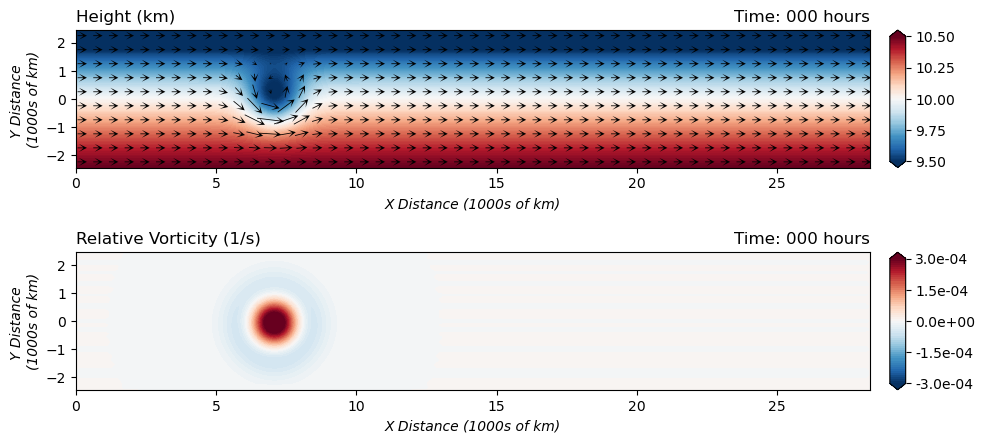

()

In [12]:
# plot the first output time step
make_plot(out=0)

Before we do any more plotting, it's always a good idea to think through what we expect to happen based on these initial conditions.

Here's the last output time step, does it look as expected?

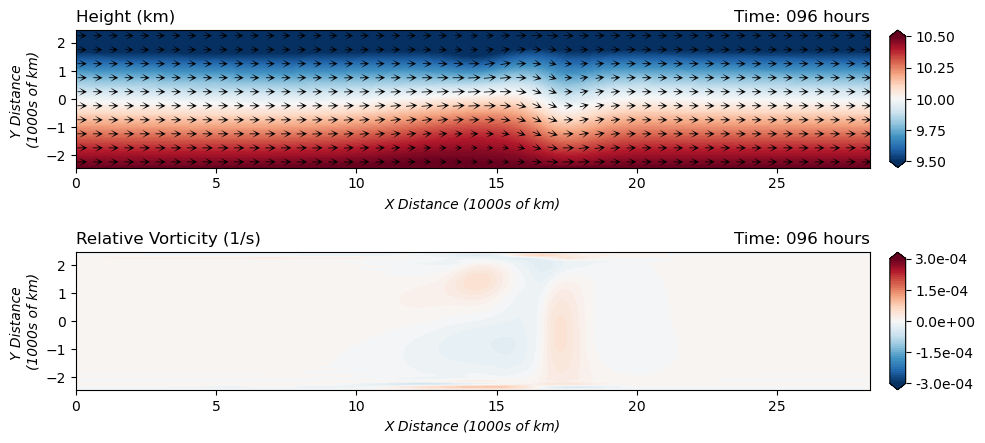

()

In [13]:
# plot the last output time step
make_plot(out=-1)

The plotting function can be called within a loop to span the entire run, or to look at several time steps in more detail. An example is given in the next cell and could be uncommented to run.

In [14]:
# plot a few time steps over entire run
#for step in np.arange(0, noutput, 48):
#    make_plot(out=step)

There is a function, make_animation_file(), to save an animation of the results to a file, for separate viewing. This takes about a minute on my laptop. 

In [15]:
# make_animation_file(outfile='cyclone_in_westerly.gif')

There is also a function to make an inline animation in the notebook, although this renders slowly (3-4 minutes on my laptop) and adds substantially to the size of the notebook.

In [16]:
# make_inline_animation()

Even though only horizontal dynamics are included in this model, a lot of interesting behavior occurs: there's an initial disturbance that propagates rapidly away from the cyclone, the cyclone moves northward as well as eastward, and a wave develops downstream from the cyclone. We may also wonder why there's a ring of negative vorticity around the cyclone and what the circulation would look like if there were a cyclone with only positive vorticity.

**How to interpret the domain**

The interpretation of the 'beta-plane' domain is based on the choice of f0 and beta.

The default parameters of f0 and beta correspond to y=0 at 45N. f0 and beta are calculated based on a central latitude, as in the next cell.

In [17]:
# calculate f0 and beta for a given central latitude

phi0 = 45
omega = 7.292e-5
re = 6.37e6
f0 = 2*omega*np.sin(phi0*np.pi/180) 
beta = 2*omega*np.cos(phi0*np.pi/180)/re

print('At a latitude of '+str(phi0)+ ', f0='+str('%.2E' % f0)+' and beta='+str('%.2E' % beta))

At a latitude of 45, f0=1.03E-04 and beta=1.62E-11


We can also calculate the approximate lat-lon range of our domain based on the same central latitude used to define f and beta.

In [18]:
# calculate latitude range, in degrees

phi0 = 45

y1 = np.amin(y)
y2 = np.amax(y)

lat1 = (y1*180/(np.pi*re))
lat2 = (y2*180/(np.pi*re))

print('latitude range: ' + "%.1f" % (lat1+phi0) + ' to ' + "%.1f" % (lat2+phi0))

# calculate longitude range, in degrees

x1 = np.amin(x)
x2 = np.amax(x)

lon1 = (x1*180/(np.pi*re))/np.cos(phi0*np.pi/180)
lon2 = (x2*180/(np.pi*re))/np.cos(phi0*np.pi/180)

print('longitude range: ' + "%.1f" % (lon1) + ' to ' + "%.1f" % (lon2))

latitude range: 23.0 to 67.0
longitude range: 0.0 to 360.0


### 6. Selected Experiments

#### 6.1 Gravity Waves

Let's run the gravity wave case (with rotation, by default). The inital height field is a Gaussian patch and the initial wind field is at rest. This experiment simulates a gravity wave, with rotation, in the midlatitudes.

In [19]:
(u_save, v_save, h_save, t_save, H, x, y) = run_model(
                                            orography = FLAT,
                                            initial_conditions = GAUSSIAN_BLOB,
                                            initially_geostrophic = False,
                                            add_random_height_noise = False)

Max Hours:  96.0
forecasting hour:  0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 10.00 11.00 12.00 13.00 14.00 15.00 16.00 17.00 18.00 19.00 20.00 21.00 22.00 23.00 24.00 25.00 26.00 27.00 28.00 29.00 30.00 31.00 32.00 33.00 34.00 35.00 36.00 37.00 38.00 39.00 40.00 41.00 42.00 43.00 44.00 45.00 46.00 47.00 48.00 49.00 50.00 51.00 52.00 53.00 54.00 55.00 56.00 57.00 58.00 59.00 60.00 61.00 62.00 63.00 64.00 65.00 66.00 67.00 68.00 69.00 70.00 71.00 72.00 73.00 74.00 75.00 76.00 77.00 78.00 79.00 80.00 81.00 82.00 83.00 84.00 85.00 86.00 87.00 88.00 89.00 90.00 91.00 92.00 93.00 94.00 95.00 96.00 

Let's plot the first output time:

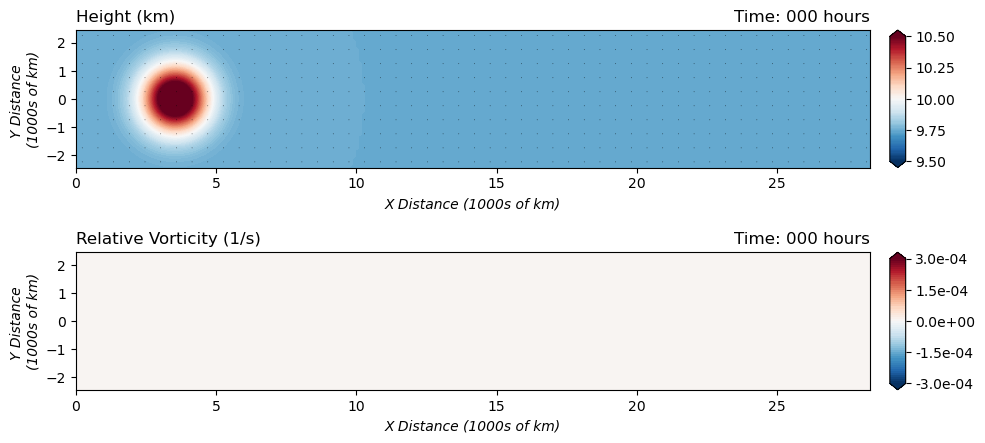

()

In [20]:
make_plot(out=0)

Let's also make a plot at the second output time.

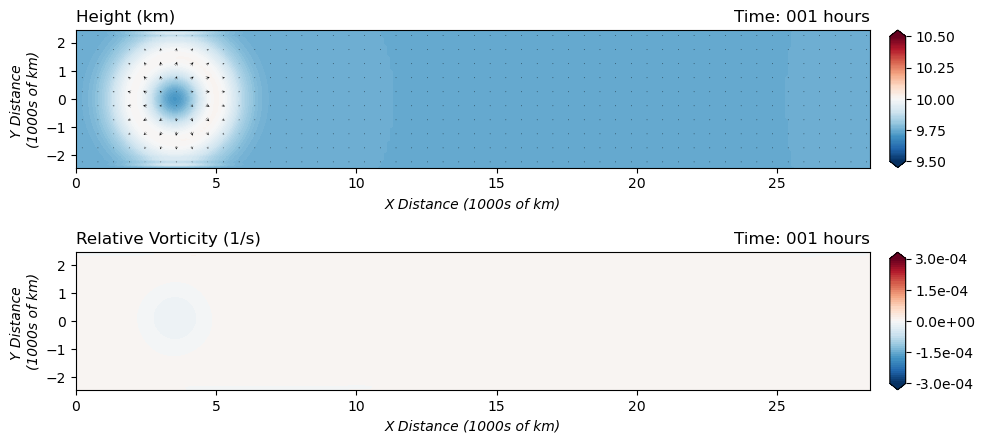

()

In [21]:
make_plot(out=1)

The wave has already spread out and lost a lot of amplitude in the process, so let's adjust our plotting parameters ...

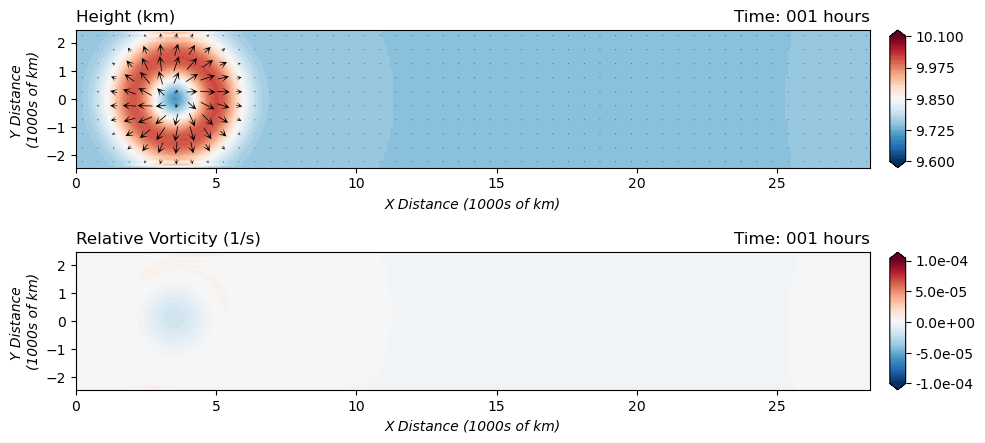

()

In [22]:
make_plot(out=1, h1=9.6e3, h2=10.1e3, vort1=-1e-4, vort2=1e-4, scale=20)

Make animation file:

In [23]:
# make_animation_file(outfile='gravity.gif')

Make inline animation:

In [24]:
# make_inline_animation()

To estimate the speed of the disturbance, we can make a longitude-time plot of the height field averaged over all latitudes. We'll focus the contour levels on a narrower range of height values, to better capture the waves after the initial disturbance.

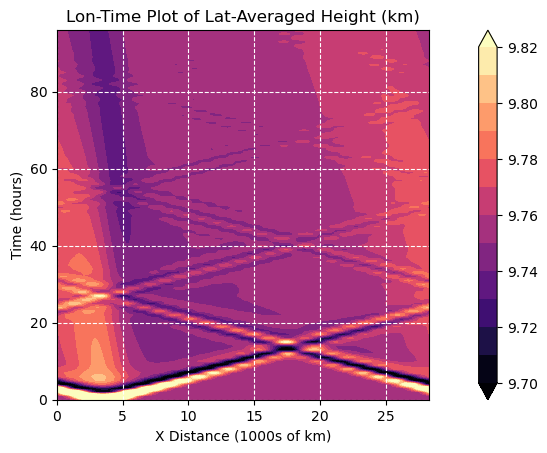

In [25]:
h_mid = np.mean(h_save, axis=1)

clevs = np.arange(9.7, 9.82, 0.01)
cf = plt.contourf(x/1e6, np.squeeze(t_save)/(60*60), h_mid.T/1e3, clevs, extend='both',
                 cmap='magma')
plt.colorbar(cf, pad=0.1)
plt.xlabel('X Distance (1000s of km)')
plt.ylabel('Time (hours)')
plt.title('Lon-Time Plot of Lat-Averaged Height (km)')
plt.grid(linestyle='dashed', color='white')
plt.show()

Some questions we could think about and explore with the model: What type of wave is criss-crossing the domain? What determines its speed? Why is there almost no vorticity? How would it behave differently if the winds were set to initially geostrophic? If rotation were turned off? Why is there both a (weak) westerward moving wave and an eastward moving wave in the longitude-time plot? Why are the wave amplitudes getting smaller with time?

#### 6.2 Tsunami

This experiment has the same initial conditions, but now with orography added. This simulates what happens as a tsunami encounters changes in depth. 

In [26]:
(u_save, v_save, h_save, t_save, H, x, y) = \
run_model(orography = SEA_MOUNT,
          initial_conditions = GAUSSIAN_BLOB,
          initially_geostrophic = False,
          add_random_height_noise = False)

Max Hours:  96.0
forecasting hour:  0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 10.00 11.00 12.00 13.00 14.00 15.00 16.00 17.00 18.00 19.00 20.00 21.00 22.00 23.00 24.00 25.00 26.00 27.00 28.00 29.00 30.00 31.00 32.00 33.00 34.00 35.00 36.00 37.00 38.00 39.00 40.00 41.00 42.00 43.00 44.00 45.00 46.00 47.00 48.00 49.00 50.00 51.00 52.00 53.00 54.00 55.00 56.00 57.00 58.00 59.00 60.00 61.00 62.00 63.00 64.00 65.00 66.00 67.00 68.00 69.00 70.00 71.00 72.00 73.00 74.00 75.00 76.00 77.00 78.00 79.00 80.00 81.00 82.00 83.00 84.00 85.00 86.00 87.00 88.00 89.00 90.00 91.00 92.00 93.00 94.00 95.00 96.00 

Plot the first output time (the orography is shown as contours):

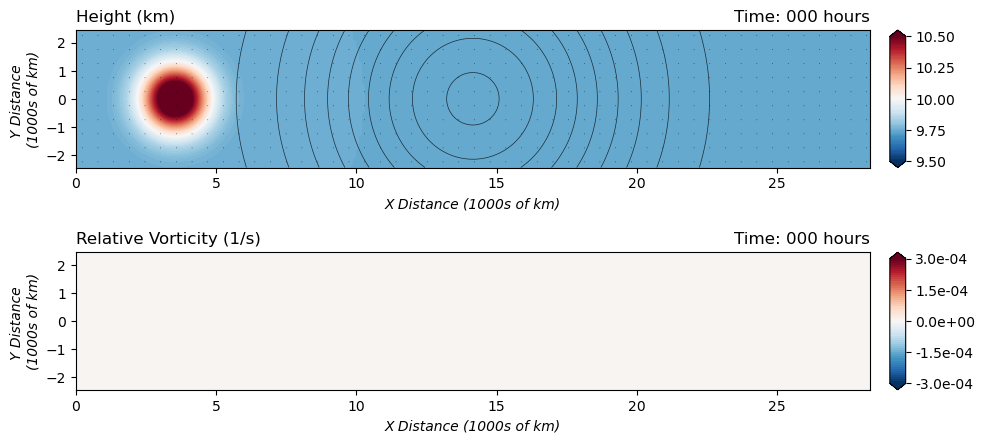

()

In [27]:
make_plot(0)

Plot a few steps later, when the eastward moving wave is encountering the orography:

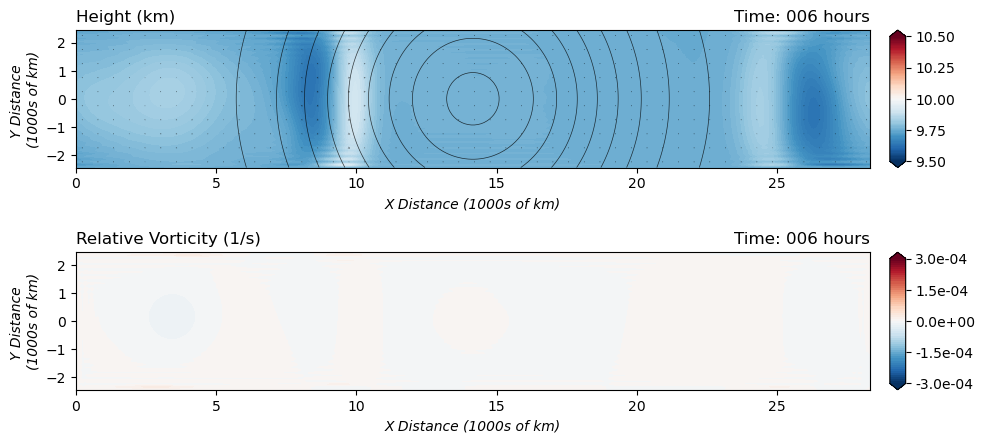

()

In [28]:
make_plot(out=6)

We can also make a longitude-time plot, to compare with the gravity wave experiment:

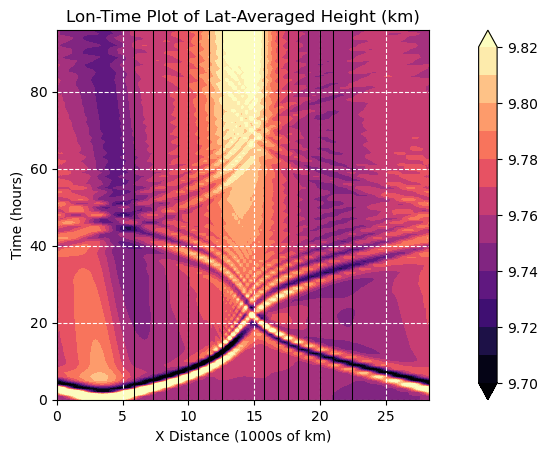

In [29]:
h_mid = np.mean(h_save + H[:, :, None], axis=1)
h_midf = np.mean(h_save[:, :, -1], axis=1)

orog = np.mean(H, axis=1)
oplot = (h_mid - h_mid + orog[:, None]).T/1e3

var = (h_mid).T/1e3

clevs = np.arange(9.7, 9.82, 0.01)
clevs_orog = np.arange(0, 10, 1)
cf = plt.contourf(x/1e6, np.squeeze(t_save)/(60*60), var, clevs, extend='both',
                 cmap='magma')
plt.contour(x/1e6, np.squeeze(t_save)/(60*60), oplot, clevs_orog, colors='black',
                 linewidths=0.75)
plt.colorbar(cf, pad=0.1)
plt.xlabel('X Distance (1000s of km)')
plt.ylabel('Time (hours)')
plt.title('Lon-Time Plot of Lat-Averaged Height (km)')
plt.grid(linestyle='dashed', color='white')
plt.show()

In [30]:
# make_animation_file(outfile='tsunami.gif')

In [31]:
# make_inline_animation()

Some questions: How does the behavior of the wave change when it encounters the orography? How does the longitude-time plot compare with the previous experiment without orography?

#### 6.3 Barotropic Instability

This experiment begins with a geostrophically-balanced zonal jet in the mid-latitudes, with a small amount of noise added. (Note that this model does not have vertical variations in any of the fields and so does not include baroclinic effects.)

In [32]:
(u_save, v_save, h_save, t_save, H, x, y) = \
run_model(orography = FLAT,
          initial_conditions = ZONAL_JET,
          initially_geostrophic = True,
          add_random_height_noise = True)

Max Hours:  96.0
forecasting hour:  0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 10.00 11.00 12.00 13.00 14.00 15.00 16.00 17.00 18.00 19.00 20.00 21.00 22.00 23.00 24.00 25.00 26.00 27.00 28.00 29.00 30.00 31.00 32.00 33.00 34.00 35.00 36.00 37.00 38.00 39.00 40.00 41.00 42.00 43.00 44.00 45.00 46.00 47.00 48.00 49.00 50.00 51.00 52.00 53.00 54.00 55.00 56.00 57.00 58.00 59.00 60.00 61.00 62.00 63.00 64.00 65.00 66.00 67.00 68.00 69.00 70.00 71.00 72.00 73.00 74.00 75.00 76.00 77.00 78.00 79.00 80.00 81.00 82.00 83.00 84.00 85.00 86.00 87.00 88.00 89.00 90.00 91.00 92.00 93.00 94.00 95.00 96.00 

Plot the first output time:

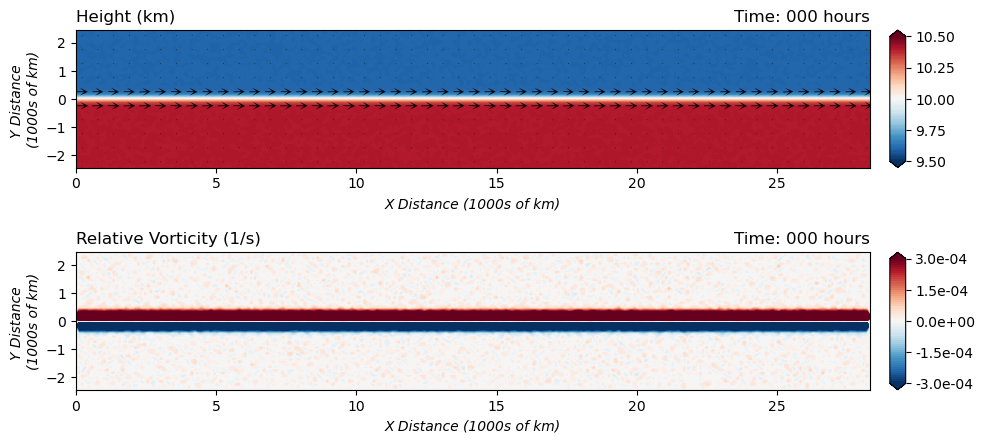

()

In [33]:
make_plot(out=0)

How might we expect the flow to evolve? Here's the last output time:

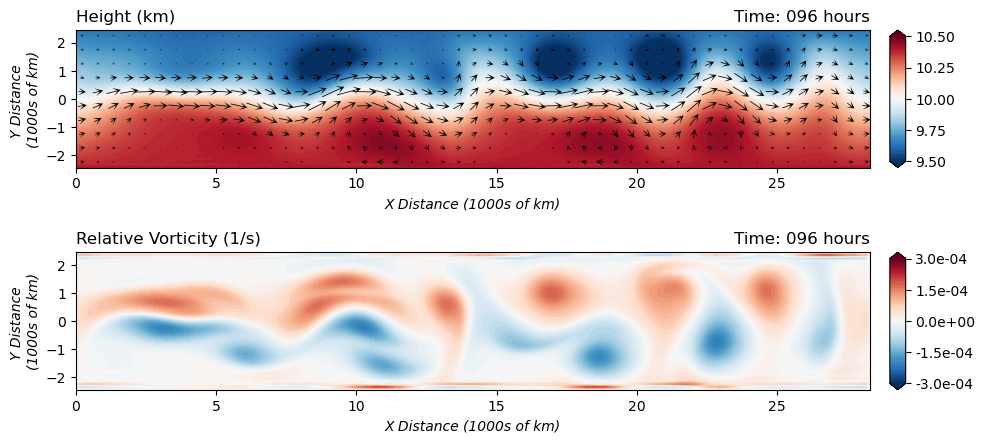

()

In [34]:
make_plot(out=-1)

Save an animation (adjusting the plotting parameters slightly):

In [35]:
# make_animation_file(outfile='barotropic_instability.gif', 
#                    scale=100, h1=9.25e3, h2=10.75e3, vort1=-4e-4, vort2=4e-4)

Make an inline animation:

In [36]:
# make_inline_animation(scale=100, h1=9.25e3, h2=10.75e3, vort1=-4e-4, vort2=4e-4)

Some questions: What changes if there's no random noise? What would be different if the initial winds were at rest? If there's no f0 or beta?

#### 6.4 Orographic Rossby Waves: Gaussian Mountain

This experiment puts an isolated mountain range in a uniform westerly flow.

In [37]:
(u_save, v_save, h_save, t_save, H, x, y) = run_model(orography = GAUSSIAN_MOUNTAIN,
                                                      initial_conditions = UNIFORM_WESTERLY,
                                                      initially_geostrophic = True)


Max Hours:  96.0
forecasting hour:  0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 10.00 11.00 12.00 13.00 14.00 15.00 16.00 17.00 18.00 19.00 20.00 21.00 22.00 23.00 24.00 25.00 26.00 27.00 28.00 29.00 30.00 31.00 32.00 33.00 34.00 35.00 36.00 37.00 38.00 39.00 40.00 41.00 42.00 43.00 44.00 45.00 46.00 47.00 48.00 49.00 50.00 51.00 52.00 53.00 54.00 55.00 56.00 57.00 58.00 59.00 60.00 61.00 62.00 63.00 64.00 65.00 66.00 67.00 68.00 69.00 70.00 71.00 72.00 73.00 74.00 75.00 76.00 77.00 78.00 79.00 80.00 81.00 82.00 83.00 84.00 85.00 86.00 87.00 88.00 89.00 90.00 91.00 92.00 93.00 94.00 95.00 96.00 

Plot the first output timestep:

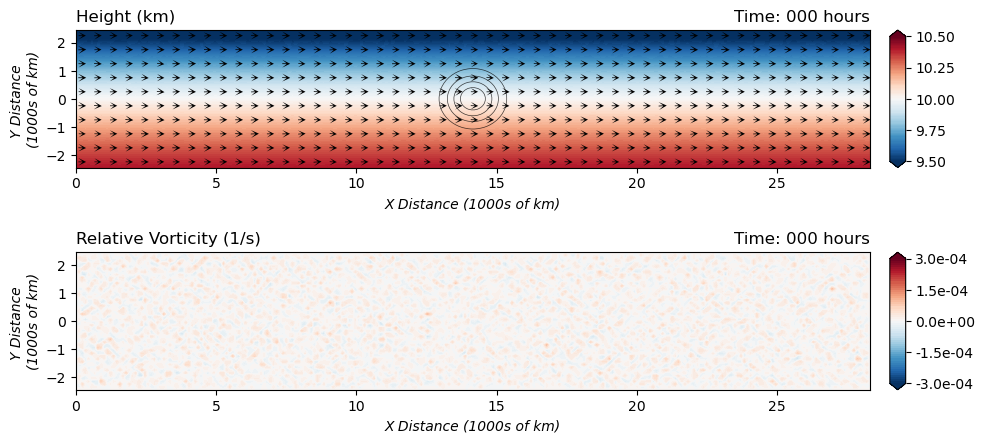

()

In [38]:
make_plot(out=0)

Plot the last output time step:

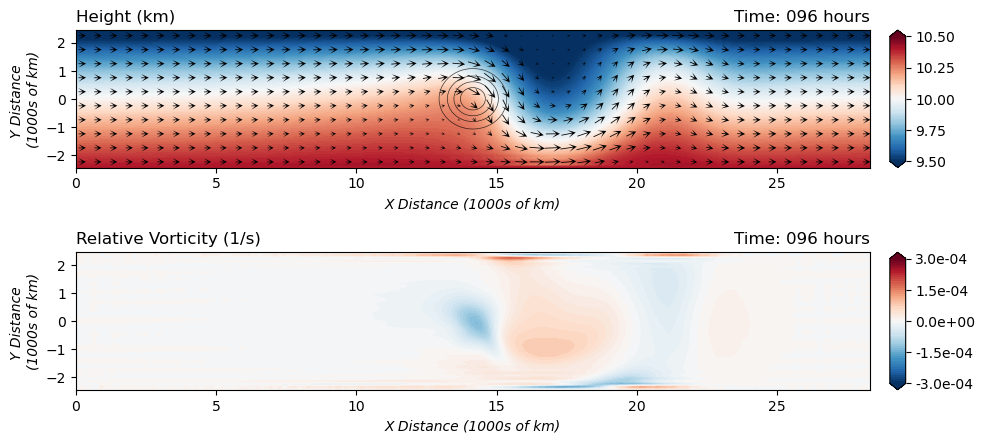

()

In [39]:
make_plot(out=-1)

Save animation file:

In [40]:
# make_animation_file(outfile='rossby_ideal_mountain.gif')

In [41]:
# make_inline_animation()

Some questions: Are there any mountain ranges that have a large downstream trough like this? Would you expect the atmospheric response to be similar or different for westerly flow encountering an individual mountain (say, a few kilometers wide)?

#### 6.5 Orographic Rossby Waves: Realistic Mountains

This experiment puts the observed orography into a uniform westerly flow.

In [42]:
(u_save, v_save, h_save, t_save, H, x, y) = \
run_model(orography = EARTH_OROGRAPHY,
          initial_conditions = UNIFORM_WESTERLY,
          initially_geostrophic = True)

Max Hours:  96.0
forecasting hour:  0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 10.00 11.00 12.00 13.00 14.00 15.00 16.00 17.00 18.00 19.00 20.00 21.00 22.00 23.00 24.00 25.00 26.00 27.00 28.00 29.00 30.00 31.00 32.00 33.00 34.00 35.00 36.00 37.00 38.00 39.00 40.00 41.00 42.00 43.00 44.00 45.00 46.00 47.00 48.00 49.00 50.00 51.00 52.00 53.00 54.00 55.00 56.00 57.00 58.00 59.00 60.00 61.00 62.00 63.00 64.00 65.00 66.00 67.00 68.00 69.00 70.00 71.00 72.00 73.00 74.00 75.00 76.00 77.00 78.00 79.00 80.00 81.00 82.00 83.00 84.00 85.00 86.00 87.00 88.00 89.00 90.00 91.00 92.00 93.00 94.00 95.00 96.00 

Plot the first output timestep:

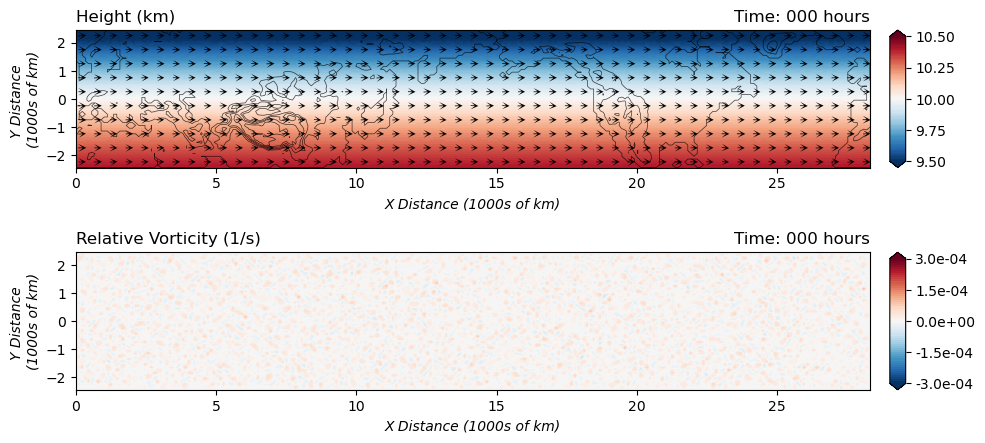

()

In [43]:
make_plot(out=0)

And the last output timestep:

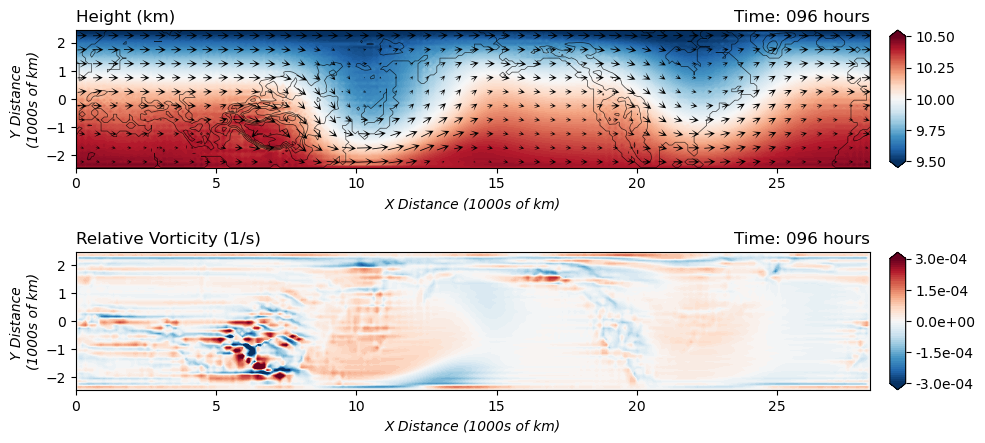

()

In [44]:
make_plot(out=-1)

Save an animation file:

In [45]:
# make_animation_file(outfile="rossby_realistic_mountains.gif")

Make an inline animation:

In [46]:
# make_inline_animation()

Some questions: How well does this fit with the observed flow, qualitatively? What are some unrealistic aspects of this experiment? How similar is this to the previous experiment with idealized flow? How much of a difference do the small-scale featuers of the orography make to the height response? To the vorticity?

#### 6.6 Equatorially Trapped Waves

Now let's consider an easterly jet, centered on the equator (set by choosing f=0, which means that y=0 corresponds to the equator).

In [47]:
(u_save, v_save, h_save, t_save, H, x, y) = \
run_model(f0=0,
          beta=2.5e-11,
          orography=FLAT,
          initial_conditions=EQUATORIAL_EASTERLY,
          add_random_height_noise=True)

Max Hours:  96.0
forecasting hour:  0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 10.00 11.00 12.00 13.00 14.00 15.00 16.00 17.00 18.00 19.00 20.00 21.00 22.00 23.00 24.00 25.00 26.00 27.00 28.00 29.00 30.00 31.00 32.00 33.00 34.00 35.00 36.00 37.00 38.00 39.00 40.00 41.00 42.00 43.00 44.00 45.00 46.00 47.00 48.00 49.00 50.00 51.00 52.00 53.00 54.00 55.00 56.00 57.00 58.00 59.00 60.00 61.00 62.00 63.00 64.00 65.00 66.00 67.00 68.00 69.00 70.00 71.00 72.00 73.00 74.00 75.00 76.00 77.00 78.00 79.00 80.00 81.00 82.00 83.00 84.00 85.00 86.00 87.00 88.00 89.00 90.00 91.00 92.00 93.00 94.00 95.00 96.00 

Plot of the first output time:

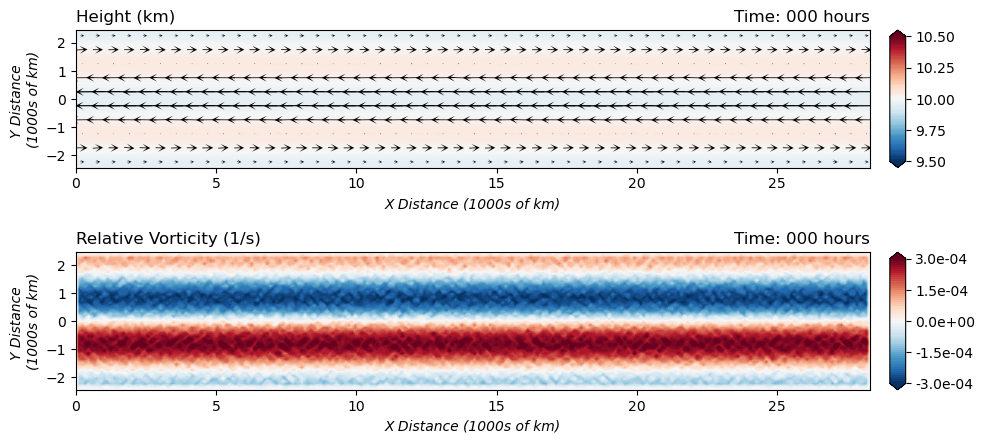

()

In [48]:
make_plot(out=0)

Plot the last output time:

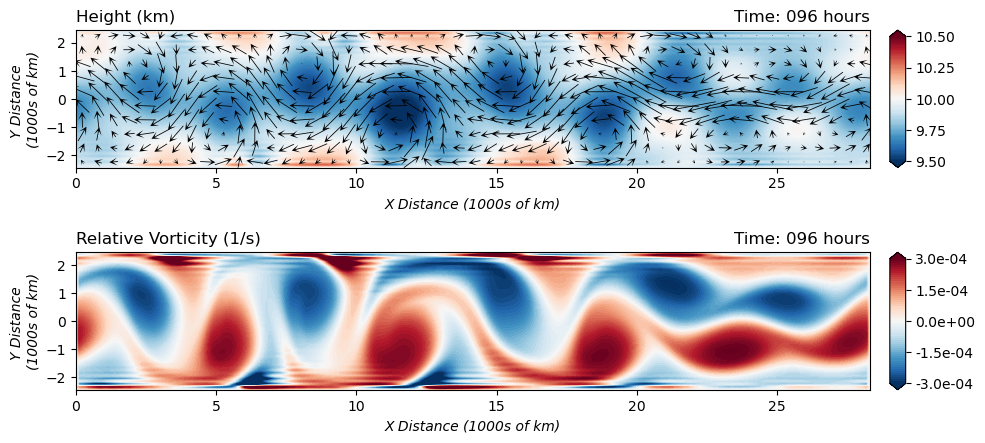

()

In [49]:
make_plot(out=-1)

In [50]:
# make_inline_animation()

Some questions: How does this differ from the midlatitude barotropic instability case? Does the relationship between height and vorticity change?

#### 6.7 Equatorial Kelvin Wave

Here we run an experiment with the same gaussian blob as in the gravity wave case, but at the equator. The same length of run is used for easy comparison but a shorter run with more frequent output would provide a clearer picture of the response.

In [51]:
(u_save, v_save, h_save, t_save, H, x, y) = \
run_model(f0=0,
          beta=5e-10,
          orography=FLAT,
          dt_mins = 0.5,
          initial_conditions=GAUSSIAN_BLOB,
          initially_geostrophic=False,
          add_random_height_noise=False)

Max Hours:  96.0
forecasting hour:  0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 10.00 11.00 12.00 13.00 14.00 15.00 16.00 17.00 18.00 19.00 20.00 21.00 22.00 23.00 24.00 25.00 26.00 27.00 28.00 29.00 30.00 31.00 32.00 33.00 34.00 35.00 36.00 37.00 38.00 39.00 40.00 41.00 42.00 43.00 44.00 45.00 46.00 47.00 48.00 49.00 50.00 51.00 52.00 53.00 54.00 55.00 56.00 57.00 58.00 59.00 60.00 61.00 62.00 63.00 64.00 65.00 66.00 67.00 68.00 69.00 70.00 71.00 72.00 73.00 74.00 75.00 76.00 77.00 78.00 79.00 80.00 81.00 82.00 83.00 84.00 85.00 86.00 87.00 88.00 89.00 90.00 91.00 92.00 93.00 94.00 95.00 96.00 

Plot the initial conditions:

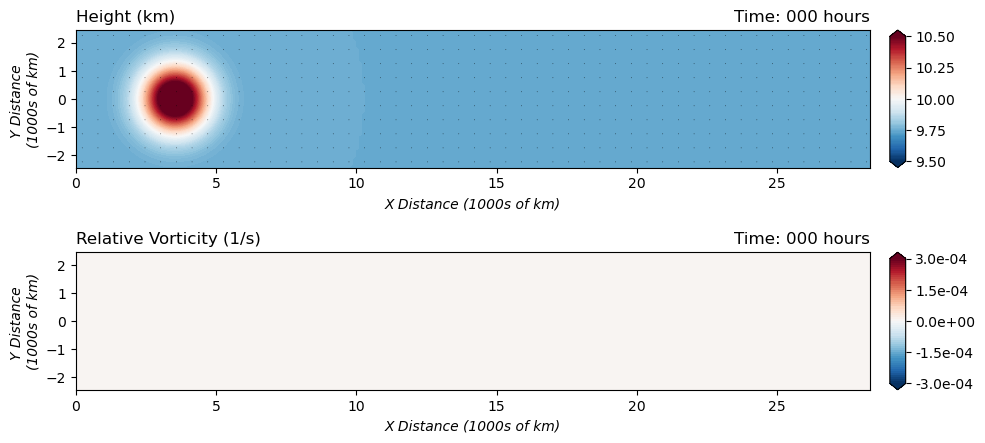

()

In [52]:
make_plot(out=0)

Plot the second output timestep:

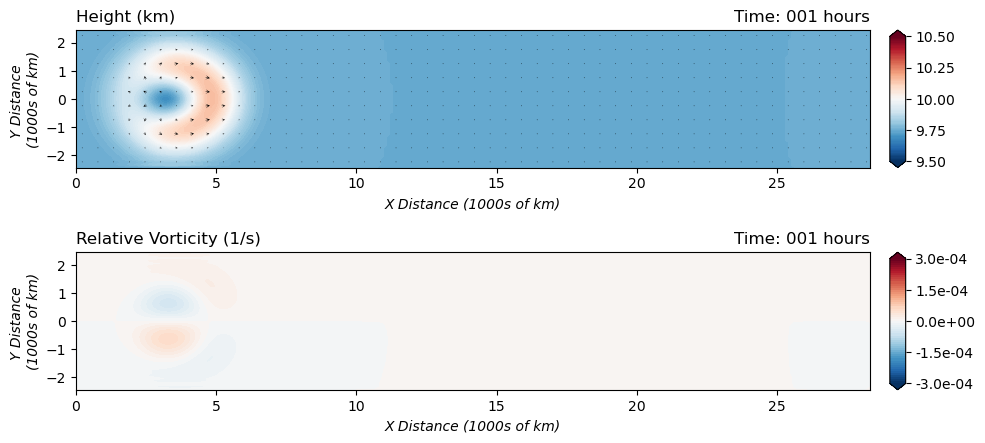

()

In [53]:
make_plot(out=1)

Probably useful to adjust our plotting parameters:

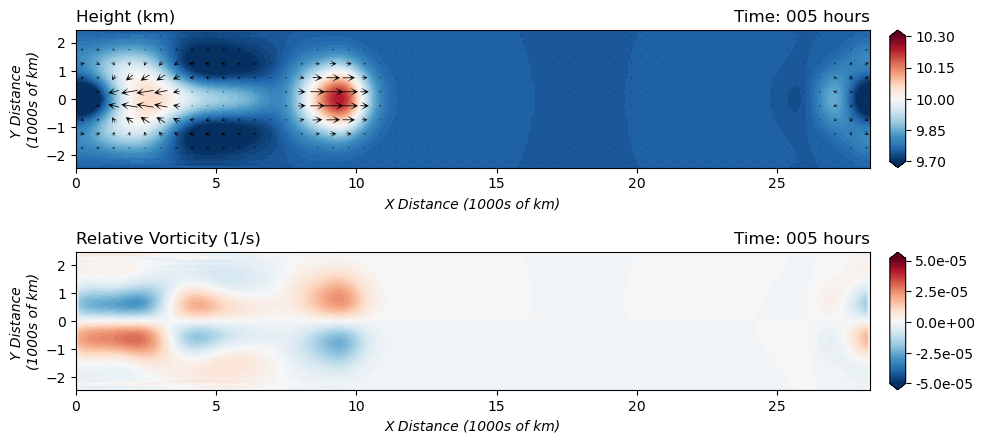

()

In [54]:
make_plot(out=5, h1=9.7e3, h2=10.3e3, vort1=-5e-5, vort2=5e-5, scale=20)

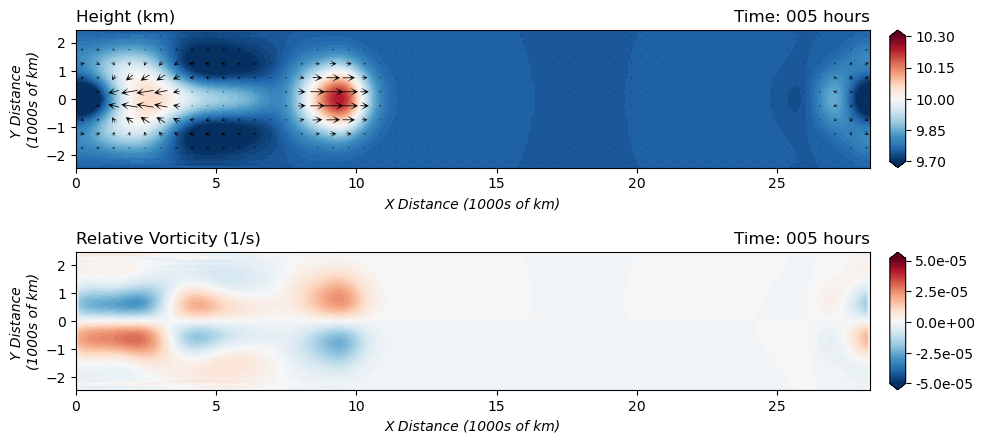

()

In [55]:
make_plot(out=5, h1=9.7e3, h2=10.3e3, vort1=-5e-5, vort2=5e-5, scale=20)

Make a longitude-time plot, to compare with the earler experment.

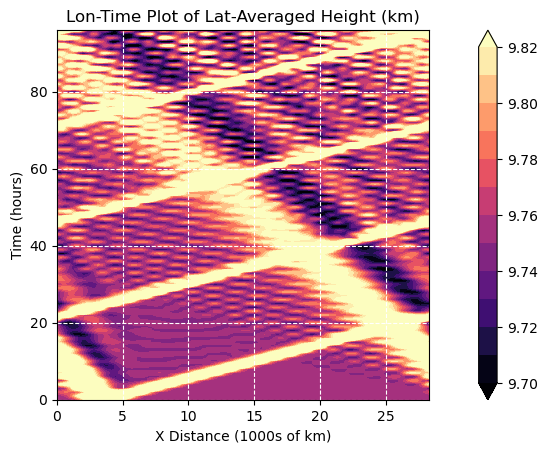

In [56]:
h_mid = np.mean(h_save, axis=1)

clevs = np.arange(9.7, 9.82, 0.01)
cf = plt.contourf(x/1e6, np.squeeze(t_save)/(60*60), h_mid.T/1e3, clevs, extend='both',
                 cmap='magma')
plt.colorbar(cf, pad=0.1)
plt.xlabel('X Distance (1000s of km)')
plt.ylabel('Time (hours)')
plt.title('Lon-Time Plot of Lat-Averaged Height (km)')
plt.grid(linestyle='dashed', color='white')
plt.show()

Save an animation file:

In [57]:
# make_animation_file(outfile='eq_kelvin.gif',
#                    h1=9.7e3, h2=10.3e3, vort1=-5e-5, vort2=5e-5, scale=20)

Make inline animation:

In [58]:
# make_inline_animation()

Some questions: This has the same initial conditions as the earlier gravity wave experiment but with changes to f0 and beta consistent with y=0 being the equator. How does that change the behavior? Why are things so different at the equator?

#### 6.8 Beta Drift

What happens to an isolated vortex (cyclone) with no environmental flow? That is, like the "cyclone in westerly" experiment but without the westerlies.

In [59]:
(u_save, v_save, h_save, t_save, H, x, y) = \
run_model(initial_conditions = GAUSSIAN_LOW,
          add_random_height_noise = False,
          dt_mins = 0.25,
          output_interval_mins = 60.,
          forecast_length_days = 4.)

Max Hours:  96.0
forecasting hour:  0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 10.00 11.00 12.00 13.00 14.00 15.00 16.00 17.00 18.00 19.00 20.00 21.00 22.00 23.00 24.00 25.00 26.00 27.00 28.00 29.00 30.00 31.00 32.00 33.00 34.00 35.00 36.00 37.00 38.00 39.00 40.00 41.00 42.00 43.00 44.00 45.00 46.00 47.00 48.00 49.00 50.00 51.00 52.00 53.00 54.00 55.00 56.00 57.00 58.00 59.00 60.00 61.00 62.00 63.00 64.00 65.00 66.00 67.00 68.00 69.00 70.00 71.00 72.00 73.00 74.00 75.00 76.00 77.00 78.00 79.00 80.00 81.00 82.00 83.00 84.00 85.00 86.00 87.00 88.00 89.00 90.00 91.00 92.00 93.00 94.00 95.00 96.00 

Plot the first output time:

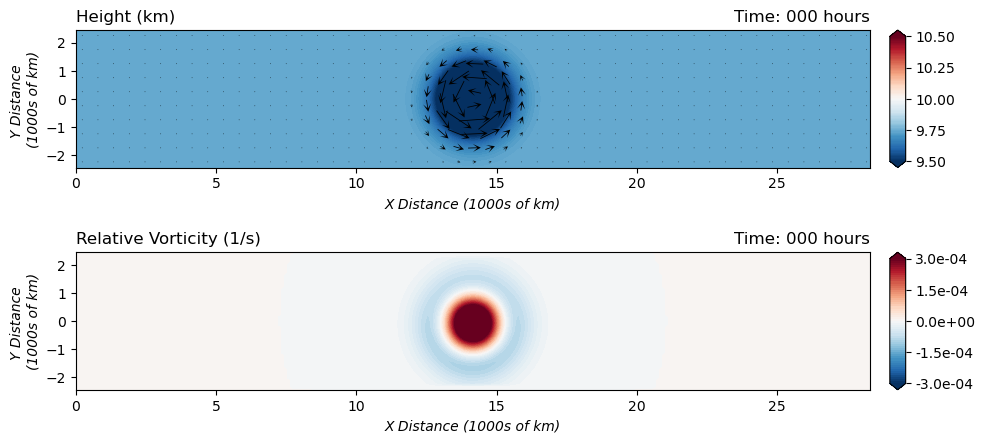

()

In [60]:
make_plot(out=0)

plot the last output time:

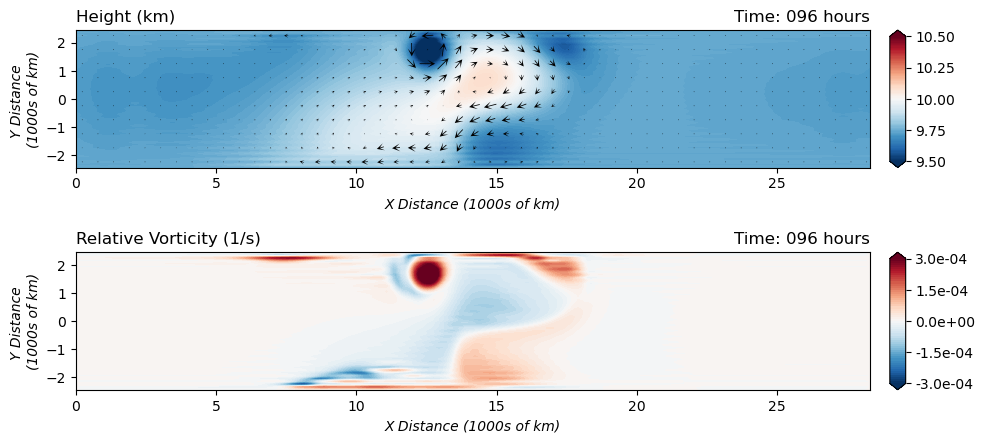

()

In [61]:
make_plot(out=-1)

Save an animation file:

In [62]:
# make_animation_file(outfile='beta_drift.gif')

Make an inline animation:

In [63]:
# make_inline_animation()

Some questions: Why is there an intial disturbance that rapidly moves away from the vortex? What could be done to reduce or eliminate that? What parameter controls the northwestward drift of the main vortex? What would the height field need to look like to have only positive vorticity in the initial wind field?

### 7. Set Your Own Initial Conditions

The model has also been modified to start with user-specified initial fields of u, v, h, and orography. This version of the model can be run with 'run_model_ic,' with the initial fields given as arguments to the model call. Some examples are given below.

#### 7.1 Example: zonal jet with no rotation

In the previous section, we looked at the (barotropic) instability of a westerly jet in the midlatitudes and an easterly jet at the equator. What about a jet in the case of no rotation? This experiment considers an initial condition with a zonal strip of constant u-wind, no v-wind, and constant height. A small amount of noise is added to u. This is essentially the simplest possible jet in a 2D fluid: how stable is it to small perturbations (noise)?

In [64]:
# make initial conditions

nx = 254
ny = 50

u0 = np.zeros((nx, ny)) 
u0[:, 20:31] = 100.0
u0 = u0 + 2*np.random.randn(nx, ny) # let's make some noise!
v0 = np.zeros((nx, ny)) 
h0 = np.zeros((nx, ny)) + 10e3 
orog = np.zeros((nx, ny))

# run model

(u_save, v_save, h_save, t_save, H, x, y) = run_model_ic(
                                            h_ic = h0,
                                            u_ic = u0,
                                            v_ic = v0,
                                            orog = orog,
                                            f0 = 0,
                                            beta = 0,
                                            nx = nx,
                                            ny = ny
                                            )

Max Hours:  96.00
forecasting hour:  0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 10.00 11.00 12.00 13.00 14.00 15.00 16.00 17.00 18.00 19.00 20.00 21.00 22.00 23.00 24.00 25.00 26.00 27.00 28.00 29.00 30.00 31.00 32.00 33.00 34.00 35.00 36.00 37.00 38.00 39.00 40.00 41.00 42.00 43.00 44.00 45.00 46.00 47.00 48.00 49.00 50.00 51.00 52.00 53.00 54.00 55.00 56.00 57.00 58.00 59.00 60.00 61.00 62.00 63.00 64.00 65.00 66.00 67.00 68.00 69.00 70.00 71.00 72.00 73.00 74.00 75.00 76.00 77.00 78.00 79.00 80.00 81.00 82.00 83.00 84.00 85.00 86.00 87.00 88.00 89.00 90.00 91.00 92.00 93.00 94.00 95.00 96.00 

Show initial conditions:

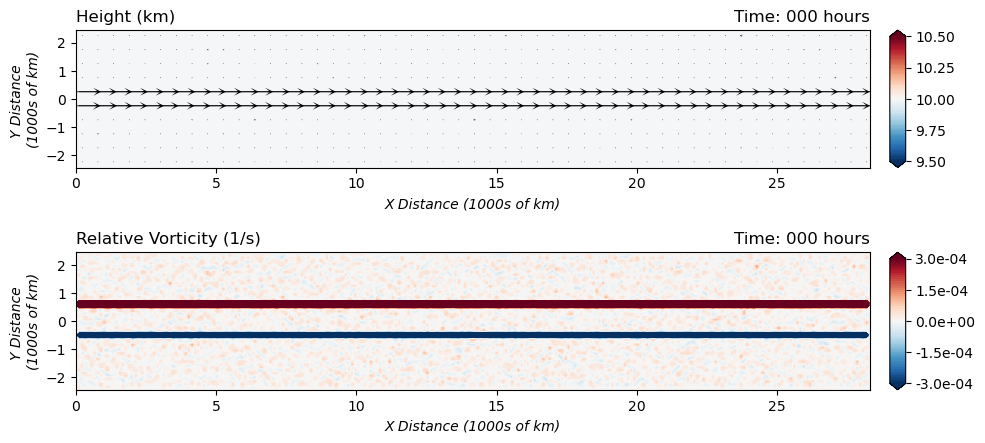

()

In [65]:
make_plot(out=0)

Show final output time step:

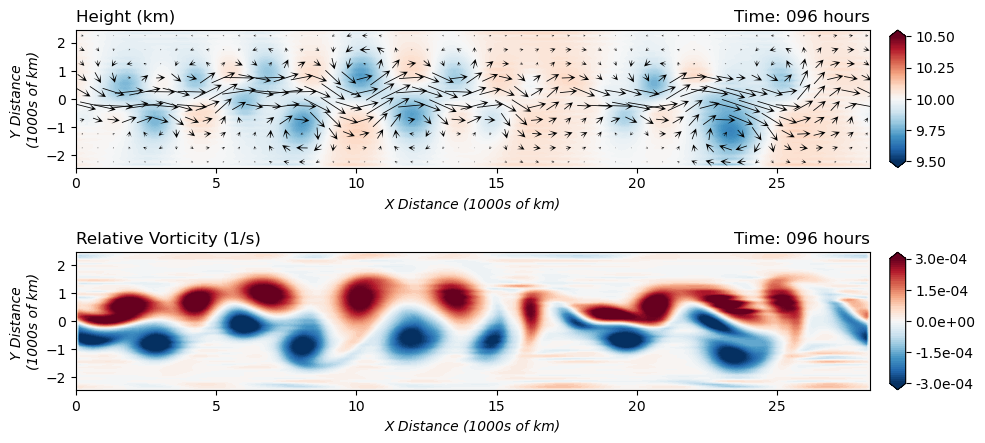

()

In [66]:
make_plot(out=-1)

Make animation file:

In [67]:
# make_animation_file(outfile='wind_strip.gif')

Make inline animation:

In [68]:
# make_inline_animation()

Questions: What does this suggest about the general stability of jets? Does rotation make a jet less stable or more stable?

#### 7.2 Example: Balanced Equatorial Kelvin Wave

In the previous Kelvin wave example, the initial wind field was at rest. Here let's add a balanced zonal wind field. (Note that we're also changing the time step and doing a shorter run.)

In [69]:

# start with the Gaussian blob for height as before
# but now also use the same function for winds, to make
# a balanced initial state

# prep work for making initial conditions

g = 9.81
re = 6.378e6
h_ref = 9750
c = np.sqrt(g*h_ref)
beta = 5e-10
t_scale = np.sqrt(1/(c*beta))
l_scale = np.sqrt(c/beta)

nx = 254
ny = 50

dy = 111e3
dx = (2*np.pi*re/nx)
x = np.mgrid[0:nx]*dx
y = np.mgrid[0:ny]*dy
y = y - np.mean(y) 
[Y, X] = np.meshgrid(y, x)

std_blob = l_scale; # Standard deviation of blob (m)
blob = np.exp(-((X-0.25*np.mean(x))**2.+(Y-np.mean(y))**2.)/(2*std_blob**2.))

fac = 1000

# make initial conditions

h0 = h_ref + fac*blob                   # gaussian blob
u0 = fac*blob*g/(beta*std_blob**2)      # balanced u-wind
v0 = np.zeros((nx, ny))                 # no v-wind
orog = np.zeros((nx, ny))               # no orography

# run model

(u_save, v_save, h_save, t_save, H, x, y) = run_model_ic(
                                            h_ic = h0,
                                            u_ic = u0,
                                            v_ic = v0,
                                            orog = orog,
                                            f0 = 0,
                                            beta = beta,
                                            dx = dx,
                                            dy = dy,
                                            nx = nx,
                                            ny = ny,
                                            dt_mins=0.1,
                                            add_random_height_noise = False,
                                            forecast_length_days = 1)

Max Hours:  24.00
forecasting hour:  0.00 1.00 2.00 3.00 4.00 5.00 6.00 7.00 8.00 9.00 10.00 11.00 12.00 13.00 14.00 15.00 16.00 17.00 18.00 19.00 20.00 21.00 22.00 23.00 24.00 

Plot the initial conditions:

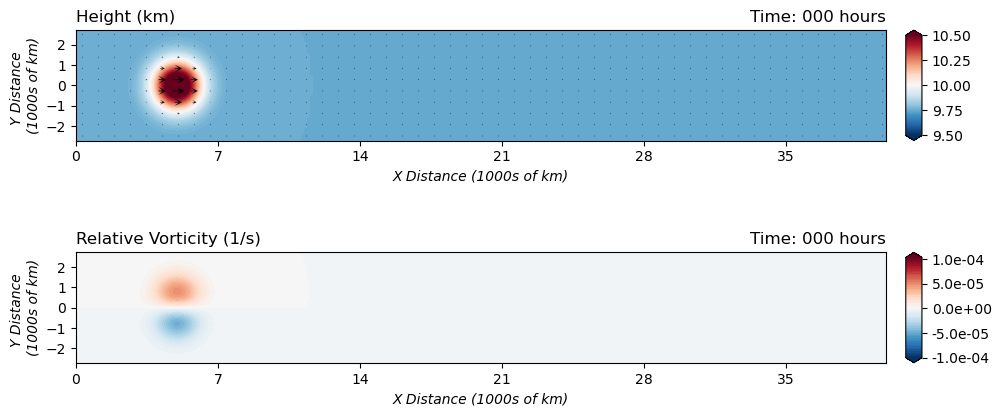

()

In [70]:
make_plot(out=0, vort1=-1e-4, vort2=1e-4, scale=50)

Plot after 24 hours:

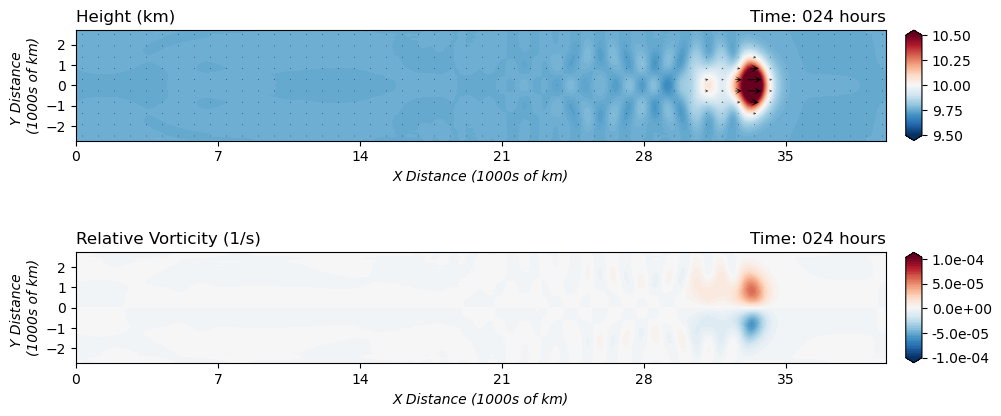

()

In [71]:
make_plot(out=24, vort1=-1e-4, vort2=1e-4, scale=50)

Make inline animation:

In [72]:
# make_inline_animation()

Some questions: How is this different from the previous Kelvin wave example? What's causing the changes to the disturbance over time? What happens if the model is run out to four days?

**Linear version** The standard set of equatorial waves is derived based on the shallow water model linearized about a resting back state (no advection). We can see what happens to the same experiment if we run a version of the model without advection. (Note that advection is only approximately removed.)

In [73]:
# model with advection removed (poorly)
# this is a very preliminary version of the model

# start with the Gaussian blob for height as before
# but now also use the same function for winds, to make
# a balanced initial state

h_ref = 9750
c = np.sqrt(g*h_ref)
beta = 5e-10
t_scale = np.sqrt(1/(c*beta))
l_scale = np.sqrt(c/beta)

std_blob = l_scale; # Standard deviation of blob (m)
blob = np.exp(-((X-0.25*np.mean(x))**2.+(Y-np.mean(y))**2.)/(2*std_blob**2.))

fac = 1000
h0 = h_ref + fac*blob
u0 = fac*blob*g/(beta*std_blob**2)
v0 = np.zeros((nx, ny))
orog = np.zeros((nx, ny))

# run the (kind of) linear model

(u_save, v_save, h_save, t_save, H, x, y) = run_linear_model_ic(
                                            h_ic = h0,
                                            u_ic = u0,
                                            v_ic = v0,
                                            orog = orog,
                                            f0 = 0,
                                            beta = beta,
                                            dx = dx,
                                            dy = dy,
                                            nx = nx,
                                            ny = ny,
                                            dt_mins=0.1,
                                            add_random_height_noise = False,
                                            forecast_length_days = 1)

Max Hours:  24 forecasting hour:  0.0 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0 13.0 14.0 15.0 16.0 17.0 18.0 19.0 20.0 21.0 22.0 23.0 24.0 

In the linear case, we expect the initial Kelvin wave disturbance to keep its form and speed constant, indefininitely. Let's check if that happens in our (mostly) linear version of the mode.

Plot the initial conditions (same as before)

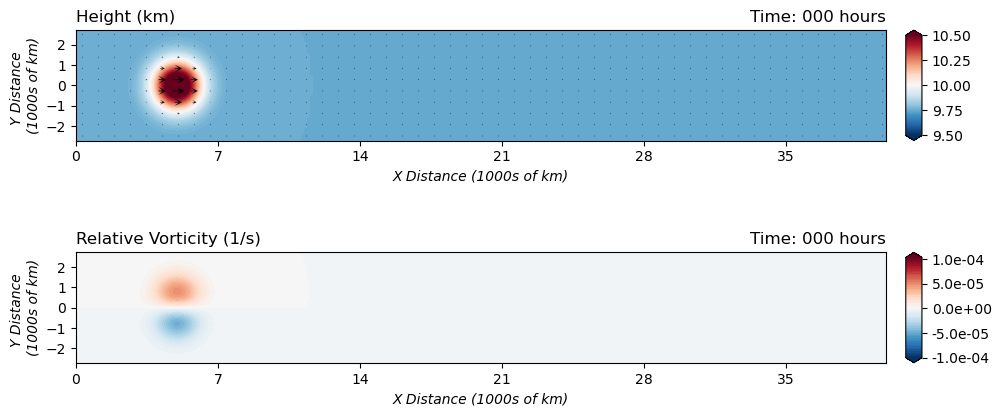

()

In [74]:
make_plot(out=0, vort1=-1e-4, vort2=1e-4, scale=50)

Plot 24 hours later:

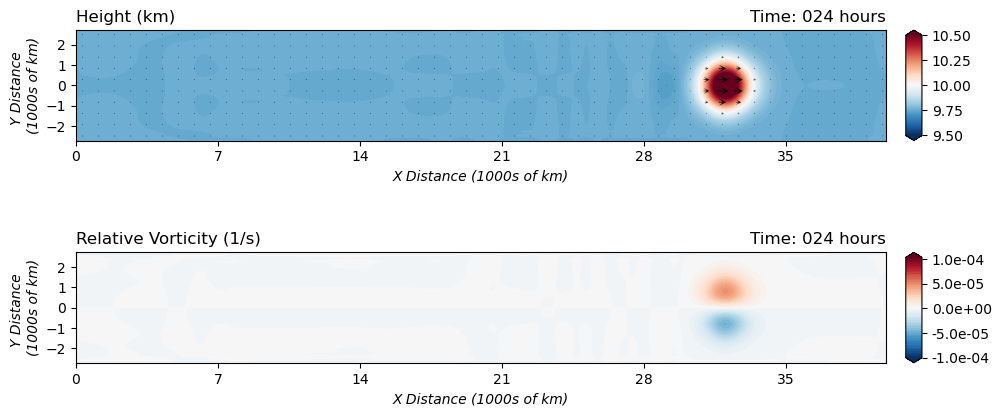

()

In [75]:
make_plot(out=24, vort1=-1e-4, vort2=1e-4, scale=50)

#### 7.3 Just For Fun

Since we can start with any initial conditions we like, why not set the initial height field based on some text?

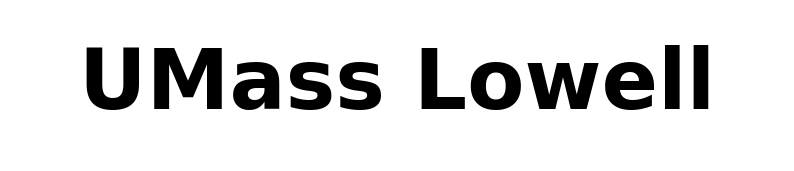

In [76]:
# make an image of some text and save to a file
plt.figure(figsize=(10, 10*ny/nx))

text = 'UMass Lowell'
plt.text(0.5, 0.5, text, dict(size=60, weight='bold'), 
         horizontalalignment='center', verticalalignment='center')
plt.axis('off')
plt.savefig("text.png", bbox_inches='tight')

In [77]:
# read in the image and interpolate to a specified grid
# note that this could be applied to any image file

nx = 254
ny = 75

dy = 100e3
dx = (2*np.pi*re/nx)
x = np.mgrid[0:nx]*dx
y = np.mgrid[0:ny]*dy
y = y - np.mean(y) 
[Y, X] = np.meshgrid(y, x)

text_array = plt.imread("text.png")
image = text_array[:, :, 0]
x_image = np.linspace(x[0], x[-1], image.shape[1])
y_image = np.linspace(y[-1], y[0], image.shape[0])
interp = RegularGridInterpolator((y_image, x_image), image)

gim = interp((Y, X)) # here's our image on the grid

In [78]:
# define the initial condtions and run the model

h0 = 10.4*1e3-gim*9*1e2      # height field based on image

u0 = np.zeros((nx, ny))      # no u-wind
v0 = np.zeros((nx, ny))      # no v-wind
orog = np.zeros((nx, ny))    # no orography

(u_save, v_save, h_save, t_save, H, x, y) = run_model_ic(
                                            h_ic = h0,
                                            u_ic = u0,
                                            v_ic = v0,
                                            orog = orog,
#                                            f0 = 0,
#                                            beta = beta,
                                            dx = dx,
                                            dy = dy,
                                            nx = nx,
                                            ny = ny,
                                            dt_mins=0.1,
                                            add_random_height_noise = False,
                                            forecast_length_days = 0.2,
                                            output_interval_mins = 10)

Max Hours:  4.80
forecasting hour:  0.00 0.17 0.33 0.50 0.67 0.83 1.00 1.17 1.33 1.50 1.67 1.83 2.00 2.17 2.33 2.50 2.67 2.83 3.00 3.17 3.33 3.50 3.67 3.83 4.00 4.17 4.33 4.50 4.67 

Plot the first output time

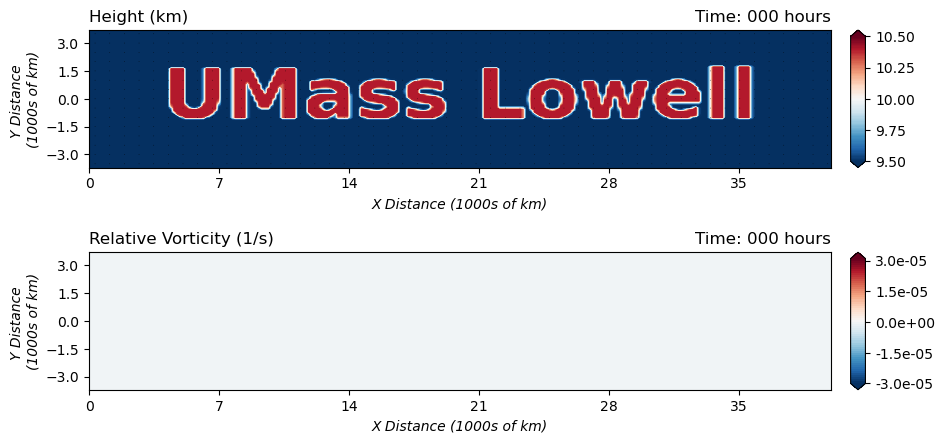

()

In [79]:
make_plot(out=0, vort1=-3e-5, vort2=3e-5)

Plot the last output time

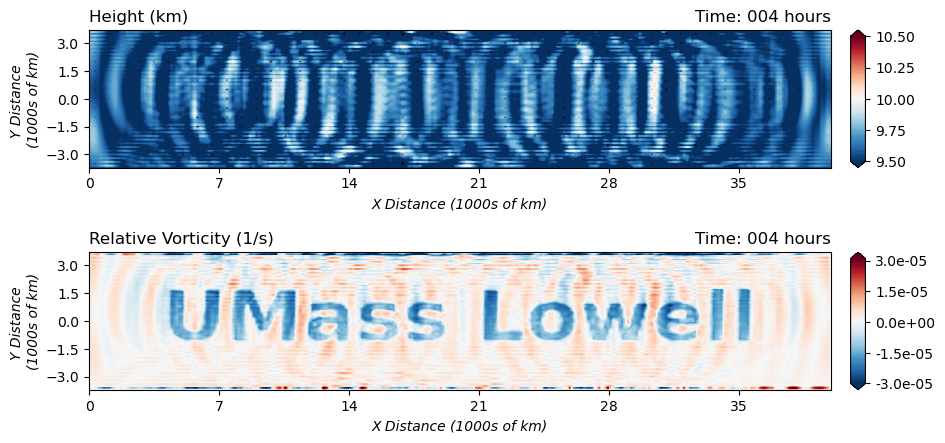

()

In [80]:
make_plot(out=-1, vort1=-3e-5, vort2=3e-5)

Save an animation file:

In [81]:
# make_animation_file(outfile='umass_lowell.gif', vort1=-3e-5, vort2=3e-5, duration=100)

Make an inline animation:

In [82]:
# make_inline_animation()

### 8. To Do

code: rankine vortex, forcing and drag for Gill experiment, two-layer version, add lateral sponge, improve handling of chanel boundaries, nonlinear balance i.c., vortex filament case

graphics: improve visibility of vectors, make plotting routines more flexible

documentation: moar